# The following .ipynb file shows the implementation of 6 physics-based plots corresponding to Figure 10 to Figure 15.

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/CCS/finalized_model/cleaned_data.csv').iloc[:,1:]

Mounted at /content/drive


In [ ]:
!pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torchdiffeq import odeint_adjoint
import joblib  # For saving scaler models as .pkl
from tensorflow.keras.models import Model

In [ ]:
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

# Load the trained model with the correct hidden size (matching the trained model's architecture)
model = LiquidPredictionModel(input_size=8, hidden_size=32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load the saved model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/CCS/finalized_model/02best_liquid_model.pth'))
model.eval()  # Set the model to evaluation mode


# Load the scalers
scaler_X = joblib.load('/content/drive/MyDrive/CCS/finalized_model/scaler_X.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/CCS/finalized_model/scaler_y.pkl')


<ipython-input-7-9940bc72882a>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/CCS/finalized_model/02best_liquid_m

In [ ]:
df.describe(include='all').transpose()

count        mean         std         min  \
Cement                          941.0  275.763071  101.888595  102.000000   
Blast Furnace Slag              941.0   73.860414   86.357628    0.000000   
Fly Ash                         941.0   58.018491   64.363194    0.000000   
Water                           941.0  180.617322   18.749758  127.000000   
Superplasticizer                941.0    6.245595    5.340507    0.000000   
Coarse Aggregate                941.0  974.807917   77.646438  801.000000   
Fine Aggregate                  941.0  776.550053   75.074455  594.000000   
Age (day)                       941.0   32.376196   28.558690    1.000000   
Concrete compressive strength   941.0   34.887534   16.592494    2.331808   
Total Binder                    941.0  407.641977   92.429730  200.000000   

                                       25%         50%          75%  \
Cement                          190.340000  255.500000   349.000000   
Blast Furnace Slag                0.000000   20.000000   145.000000   
Fly Ash                           0.000000    0.000000   118.310000   
Water                           164.900000  183.800000   192.000000   
Superplasticizer                  0.000000    7.000000    10.300000   
Coarse Aggregate                932.000000  968.000000  1031.000000   
Fine Aggregate                  741.000000  780.000000   822.200000   
Age (day)                         7.000000   28.000000    28.000000   
Concrete compressive strength    22.629981   33.398217    44.636676   
Total Binder                    336.280000  391.350000   483.700000   

                                        max  
Cement                           540.000000  
Blast Furnace Slag               342.100000  
Fly Ash                          200.100000  
Water                            228.000000  
Superplasticizer                  22.100000  
Coarse Aggregate                1145.000000  
Fine Aggregate                   945.000000  
Age (day)                        120.000000  
Concrete compressive strength     79.400056  
Total Binder                     640.000000

# Plot 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

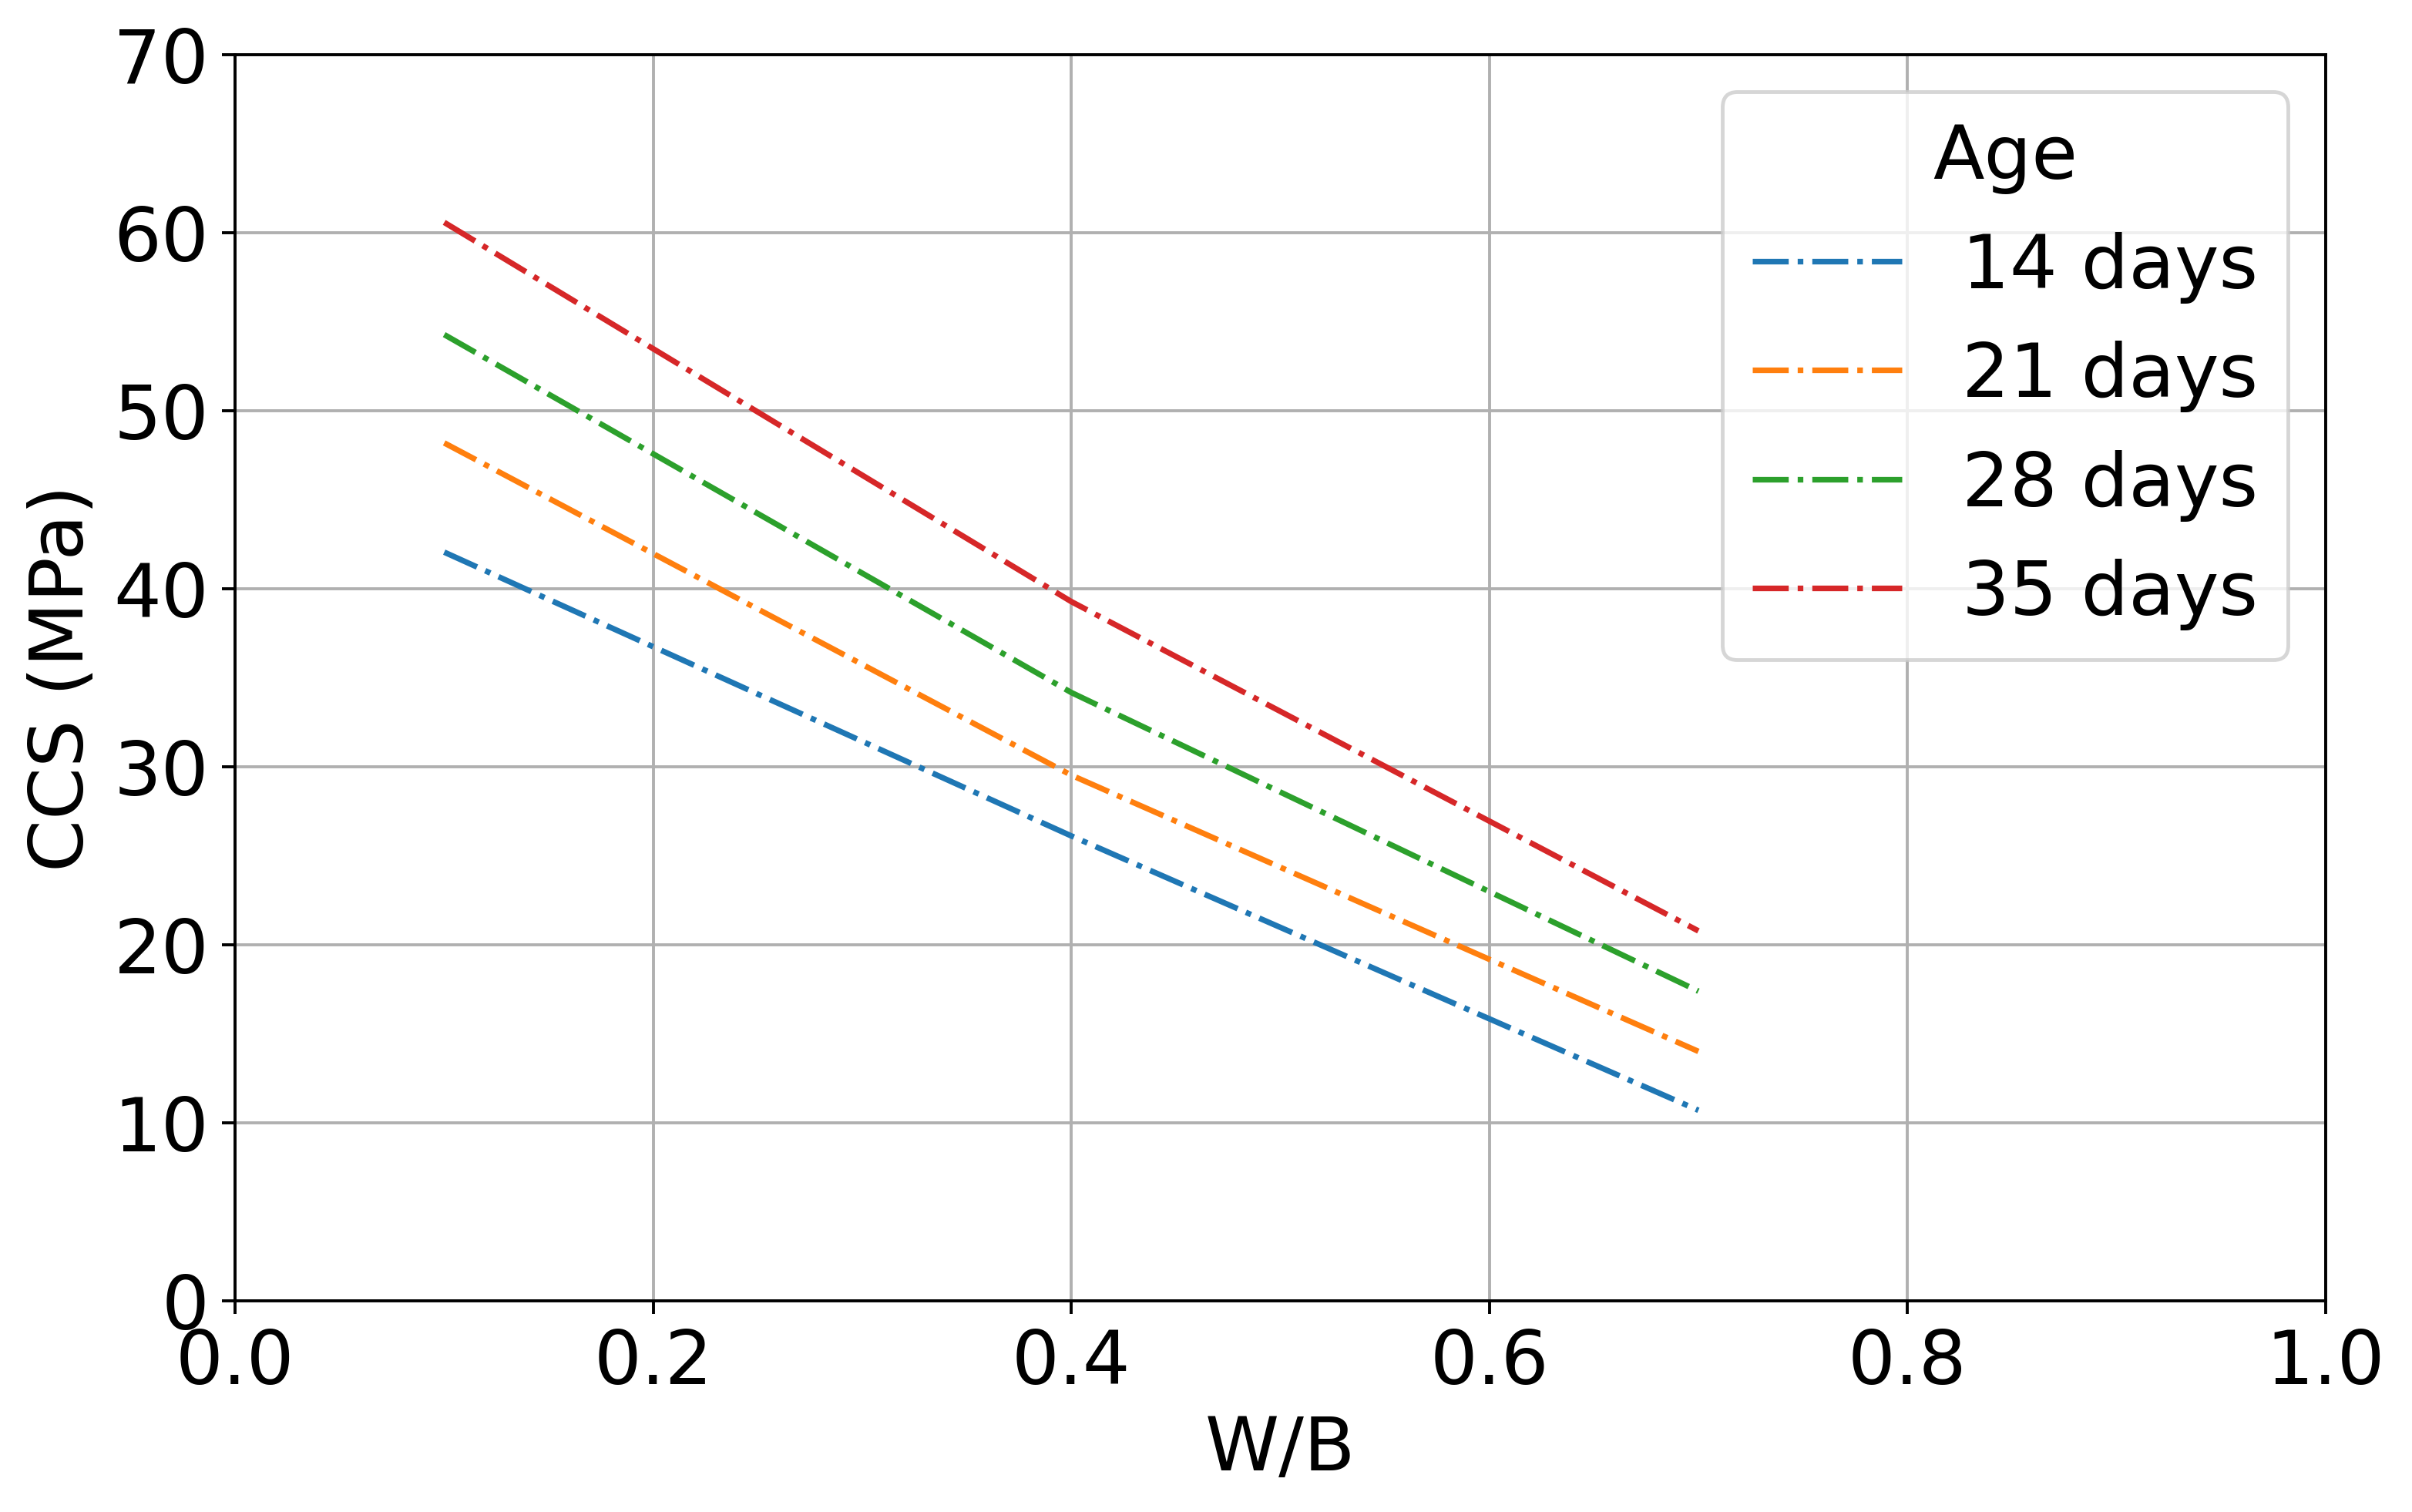

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
cement = 275.76  # Example Cement value
blast_furnace_slag = 73.86  # BFS/B = 0%
fly_ash = 58.02  # FA/B = 0%
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed)
fine_aggregate = 776.55  # Same as above
total_binder = 407.64  # Example Total Binder value
superplasticizer_percentage = 0.00  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values from 7 to 91 days

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B", fontsize=20)
plt.ylabel("CCS (MPa)", fontsize=20)
plt.legend(title='Age',fontsize=20,title_fontsize=20)
plt.grid(True)

# Set x and y limits
plt.xlim(0, 1)
plt.ylim(0, 70)

# Adjust font sizes for ticks
plt.tick_params(axis='both', labelsize=20)

# Show plot
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

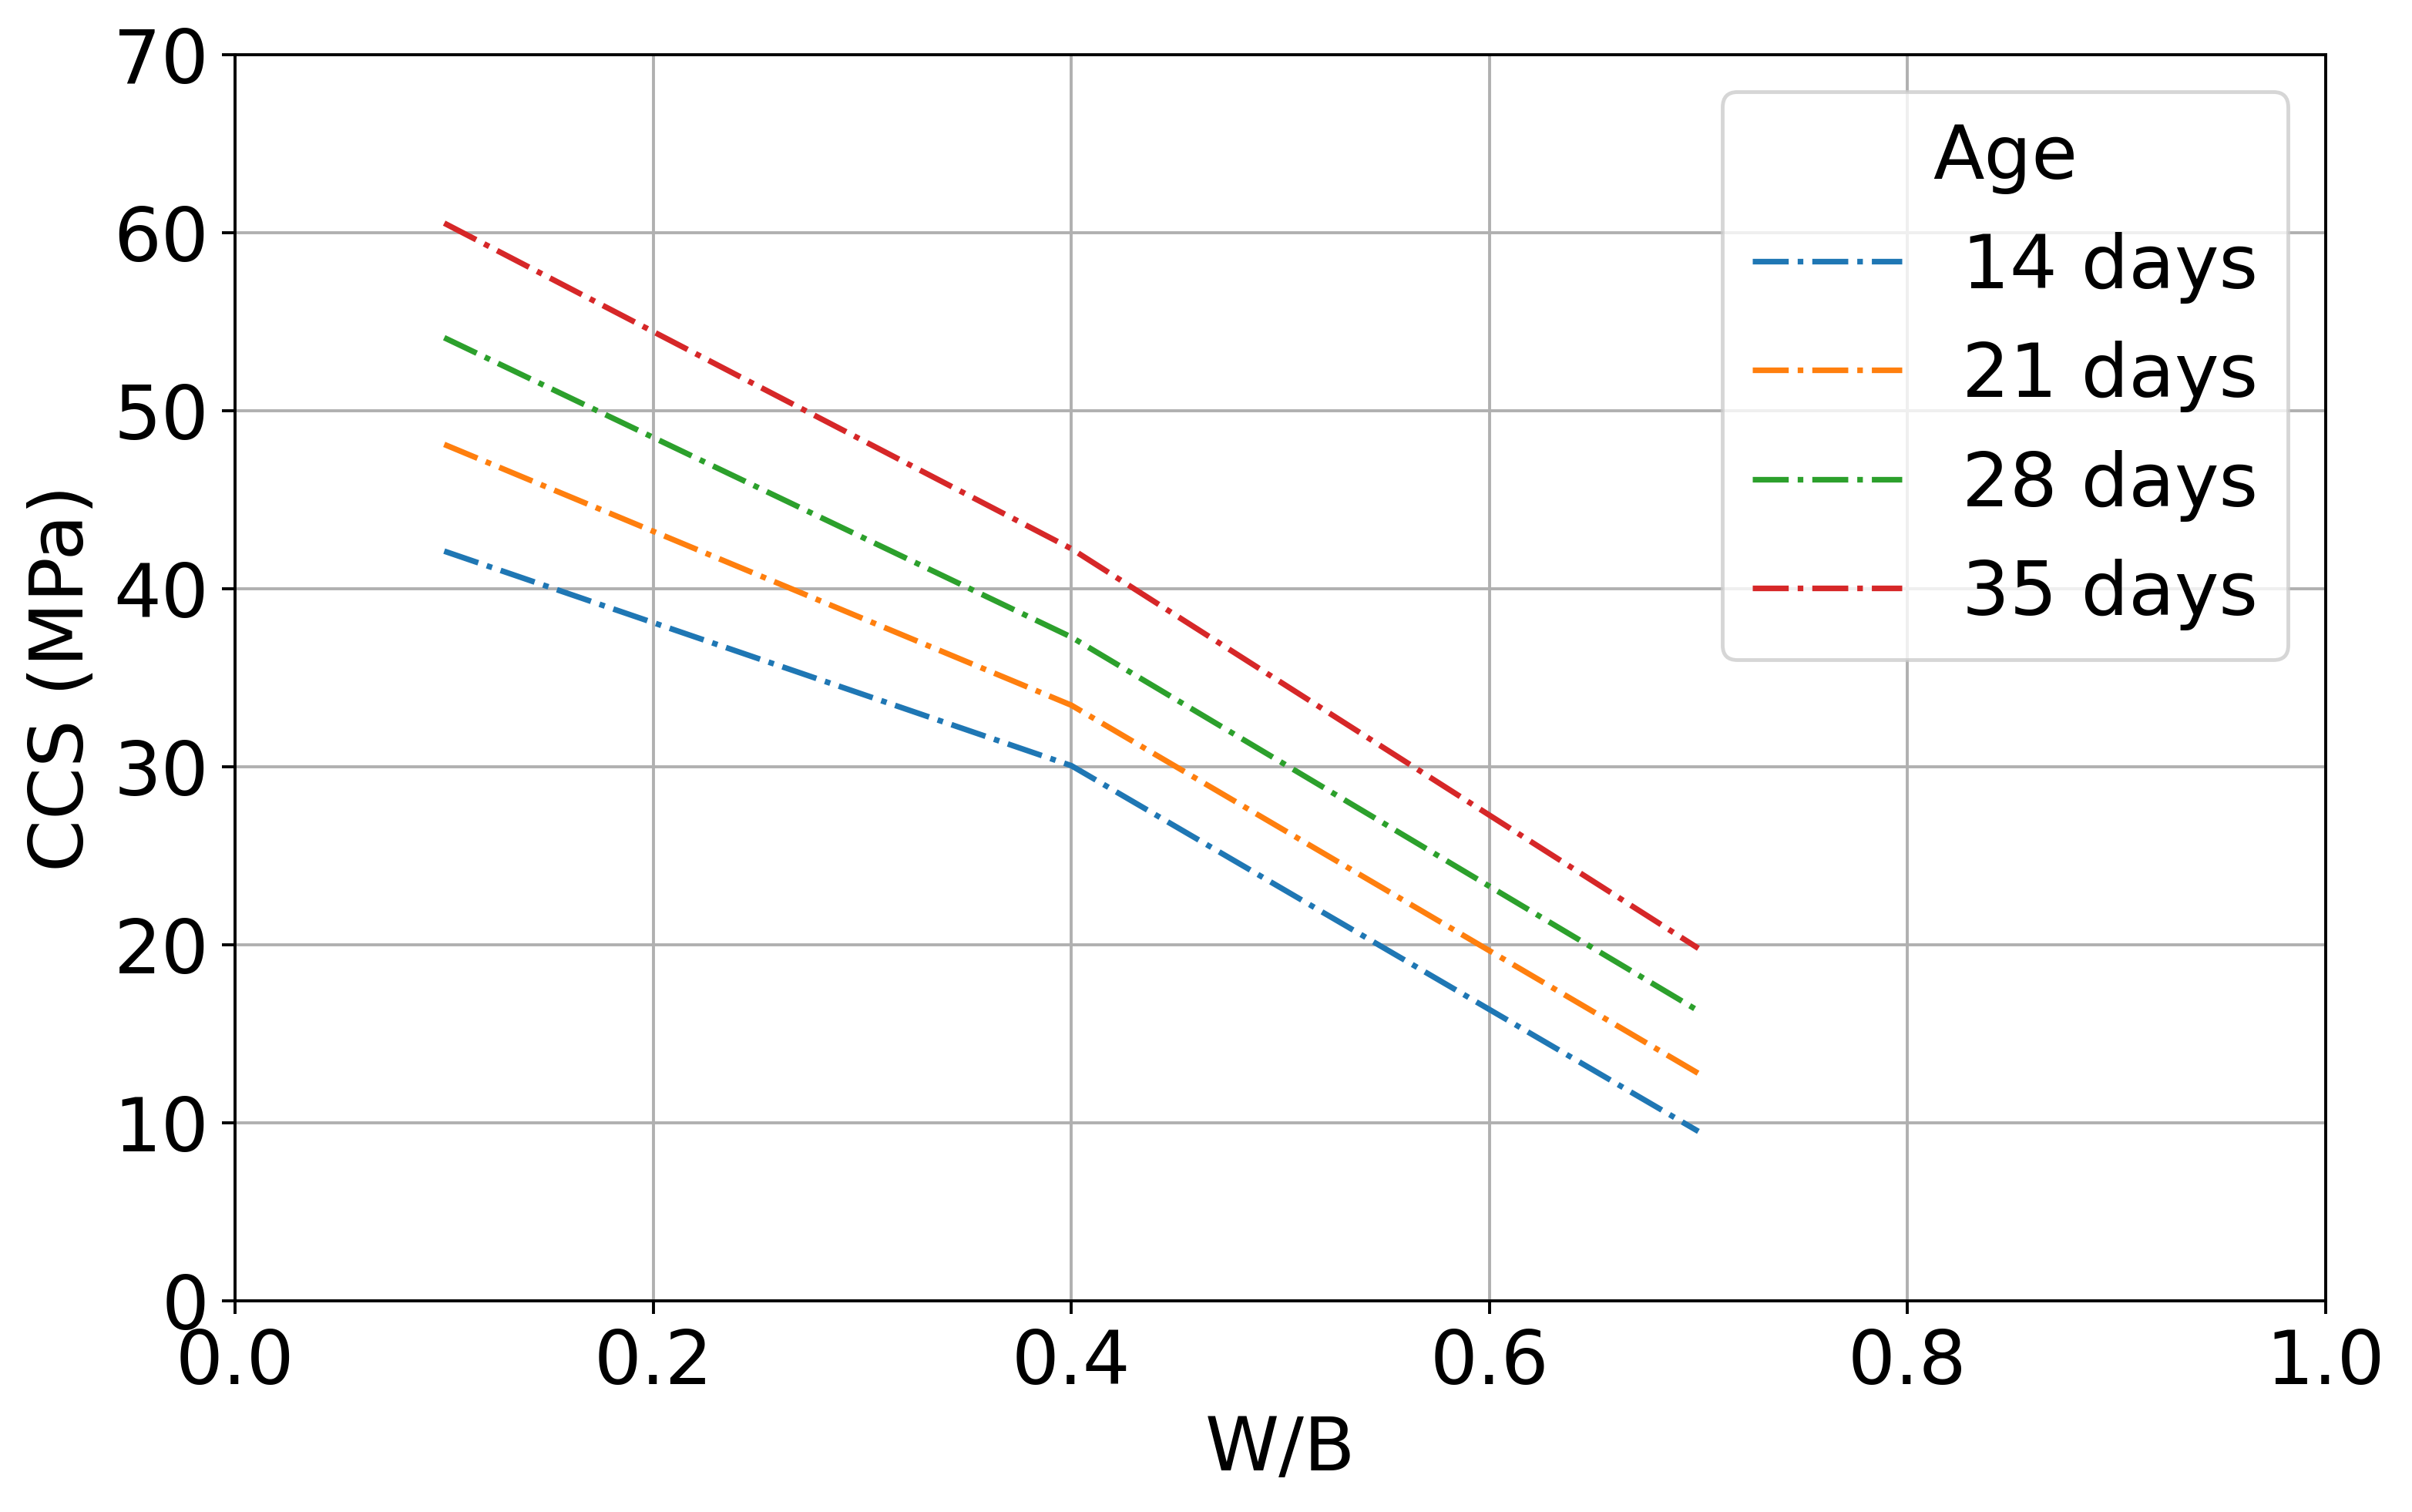

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
cement = 275.76  # Example Cement value
blast_furnace_slag = 73.86  # BFS/B = 0%
fly_ash = 58.02  # FA/B = 0%
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed)
fine_aggregate = 776.55  # Same as above
total_binder = 407.64  # Example Total Binder value
superplasticizer_percentage = 2  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values from 7 to 91 days

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B", fontsize=20)
plt.ylabel("CCS (MPa)", fontsize=20)
plt.legend(title='Age',fontsize=20,title_fontsize=20)
plt.grid(True)

# Set x and y limits
plt.xlim(0, 1)
plt.ylim(0, 70)

# Adjust font sizes for ticks
plt.tick_params(axis='both', labelsize=20)

# Show plot
plt.show()


# PLOT 2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

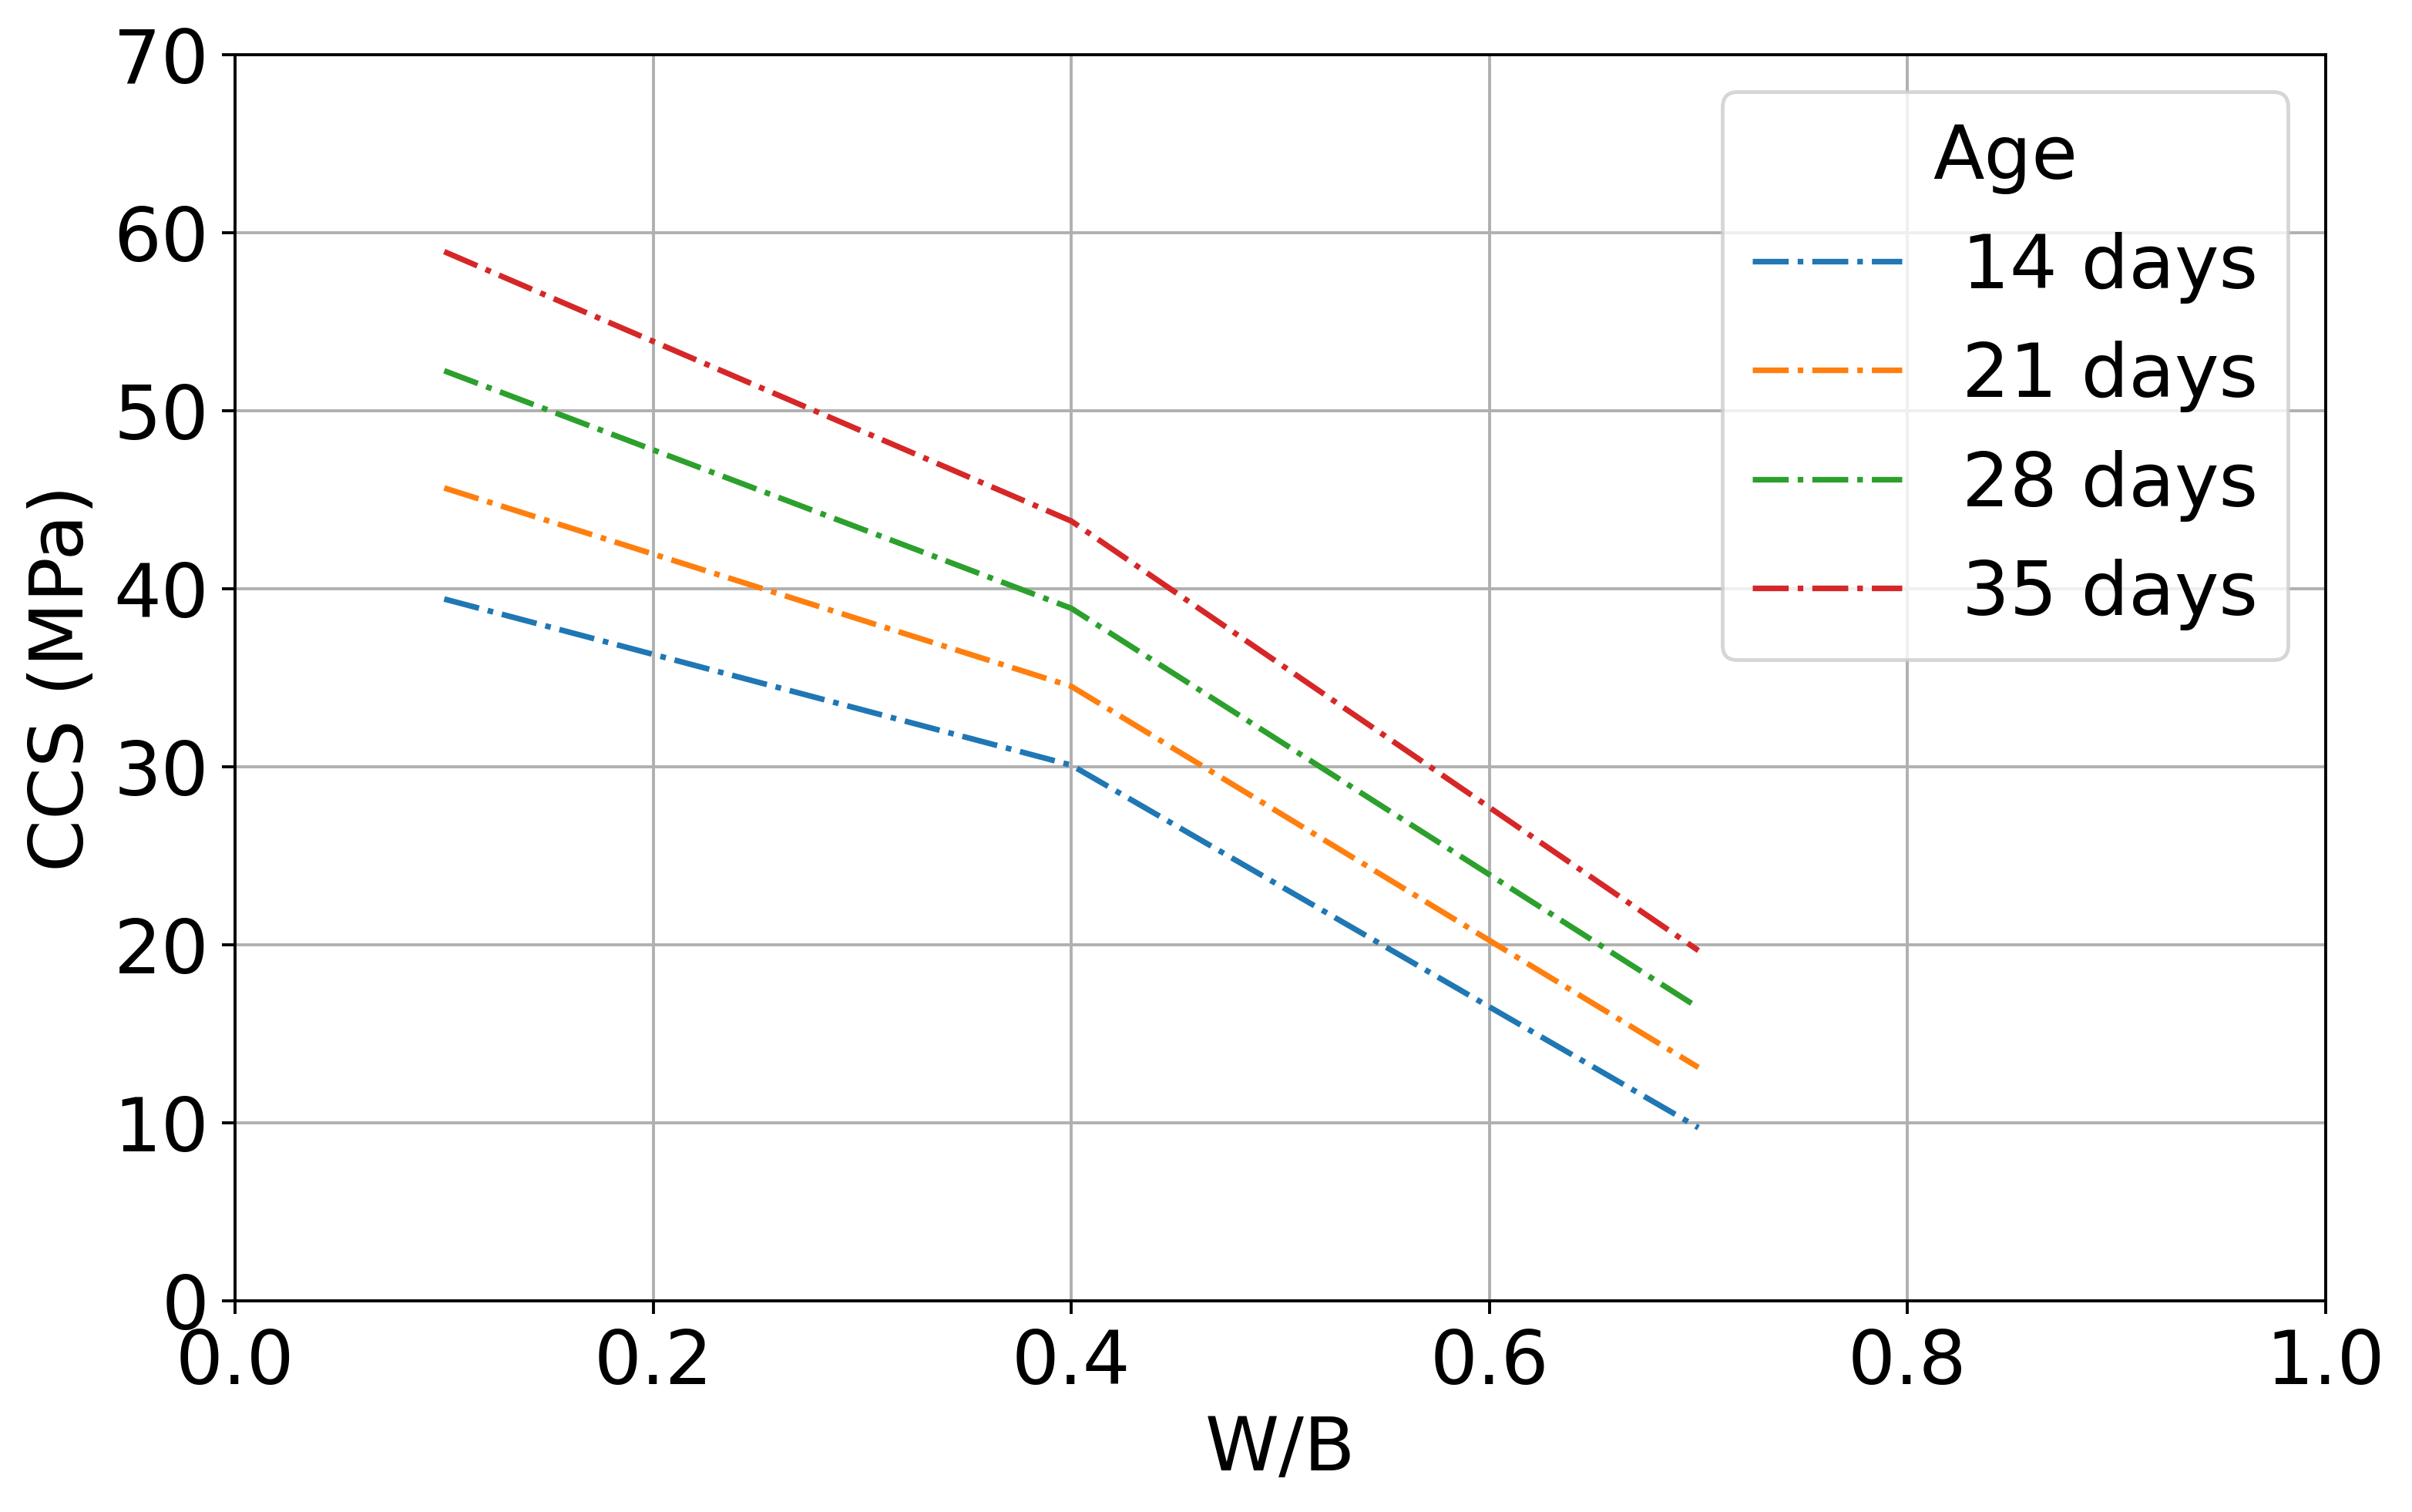

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# New relations based on BFS/B = 10%, FA/B = 10%, CA/FA = 1.20
total_binder = 407.64  # Total Binder value

# Calculating the values for BFS/B and FA/B
blast_furnace_slag = 0.10 * total_binder  # BFS/B = 10% of Total Binder
fly_ash = 0.10 * total_binder  # FA/B = 10% of Total Binder

# Fixed values for the rest of the parameters
cement = total_binder - (blast_furnace_slag + fly_ash)  # Cement content after BFS and FA
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed value)
fine_aggregate = coarse_aggregate / 1.20  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 0.00  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values to test

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 70)
plt.tick_params(axis='both', labelsize=20)

# plt.title("Concrete Compressive Strength vs. Water-to-Binder Ratio for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

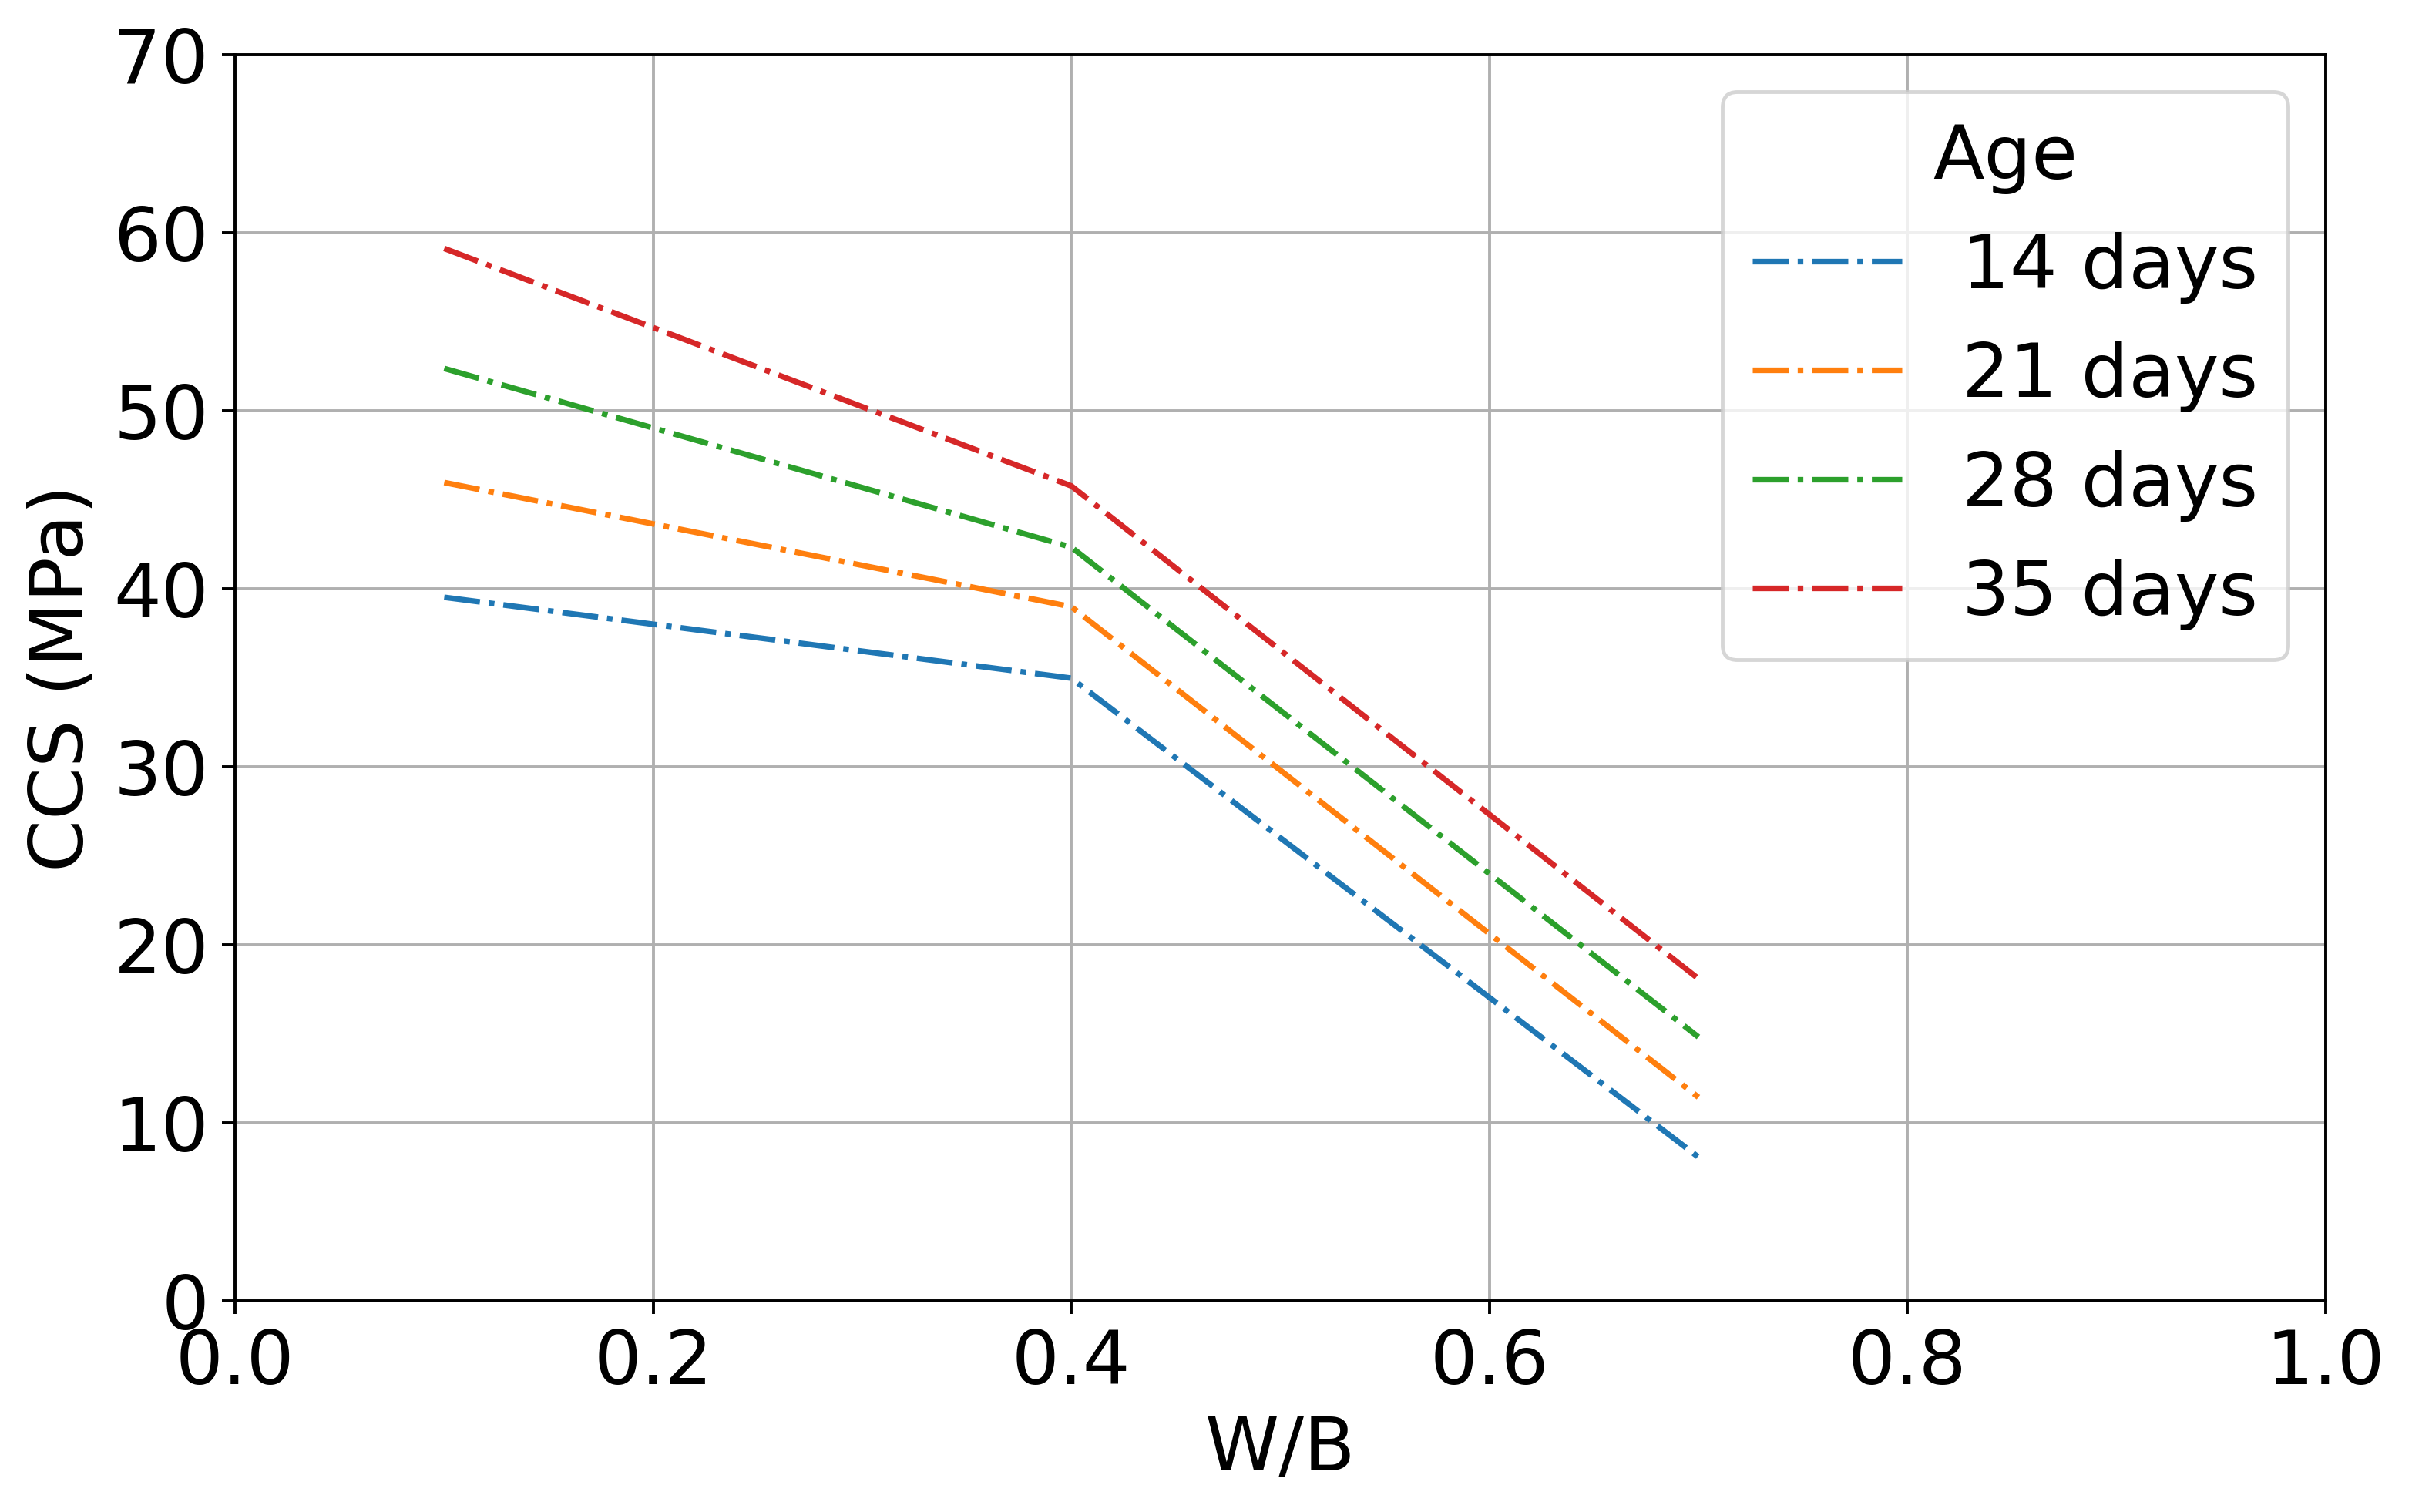

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# New relations based on BFS/B = 10%, FA/B = 10%, CA/FA = 1.20
total_binder = 407.64  # Total Binder value

# Calculating the values for BFS/B and FA/B
blast_furnace_slag = 0.10 * total_binder  # BFS/B = 10% of Total Binder
fly_ash = 0.10 * total_binder  # FA/B = 10% of Total Binder

# Fixed values for the rest of the parameters
cement = total_binder - (blast_furnace_slag + fly_ash)  # Cement content after BFS and FA
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed value)
fine_aggregate = coarse_aggregate / 1.20  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 2.00  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values to test

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 70)
plt.tick_params(axis='both', labelsize=20)

# plt.title("Concrete Compressive Strength vs. Water-to-Binder Ratio for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.grid(True)
plt.show()


# Plot 3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

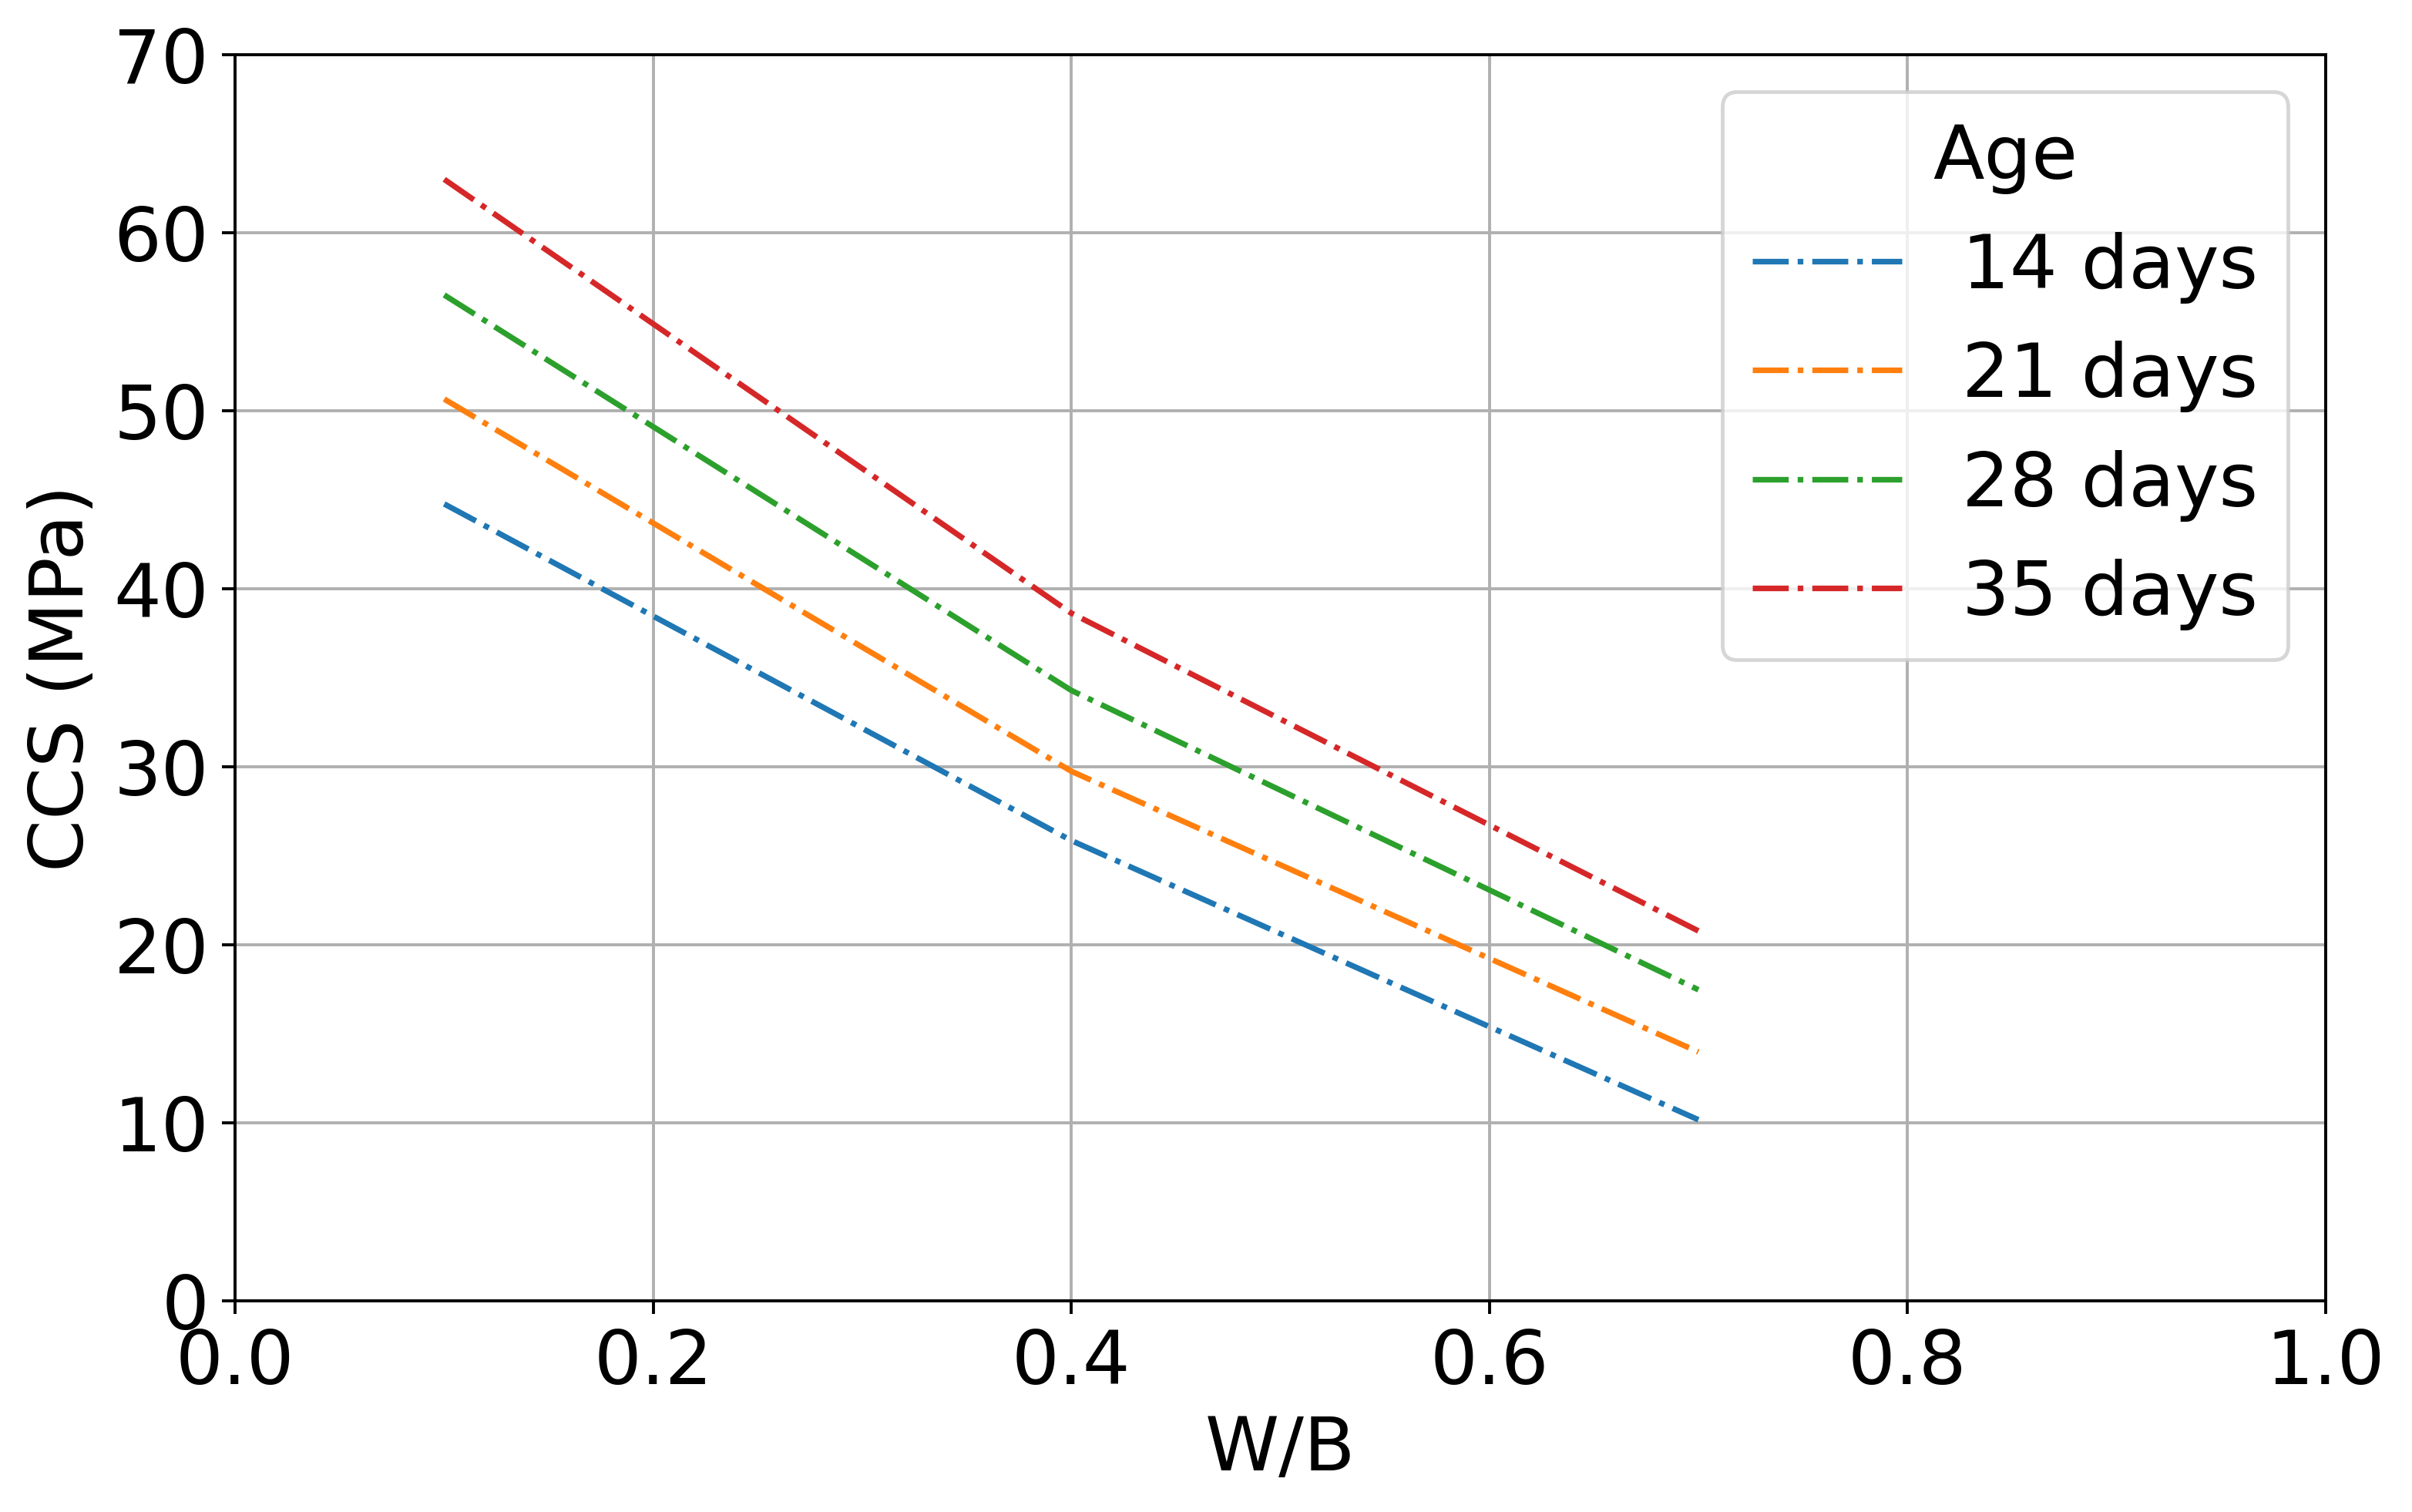

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# New relations based on BFS/B = 20%, FA/B = 20%, CA/FA = 1.20
total_binder = 407.64  # Total Binder value

# Calculating the values for BFS/B and FA/B
blast_furnace_slag = 0.20 * total_binder  # BFS/B = 20% of Total Binder
fly_ash = 0.20 * total_binder  # FA/B = 20% of Total Binder

# Fixed values for the rest of the parameters
cement = total_binder - (blast_furnace_slag + fly_ash)  # Cement content after BFS and FA
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed value)
fine_aggregate = coarse_aggregate / 1.20  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 0.00  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values to test

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 70)
plt.tick_params(axis='both', labelsize=20)
# plt.title("Concrete Compressive Strength vs. Water-to-Binder Ratio for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

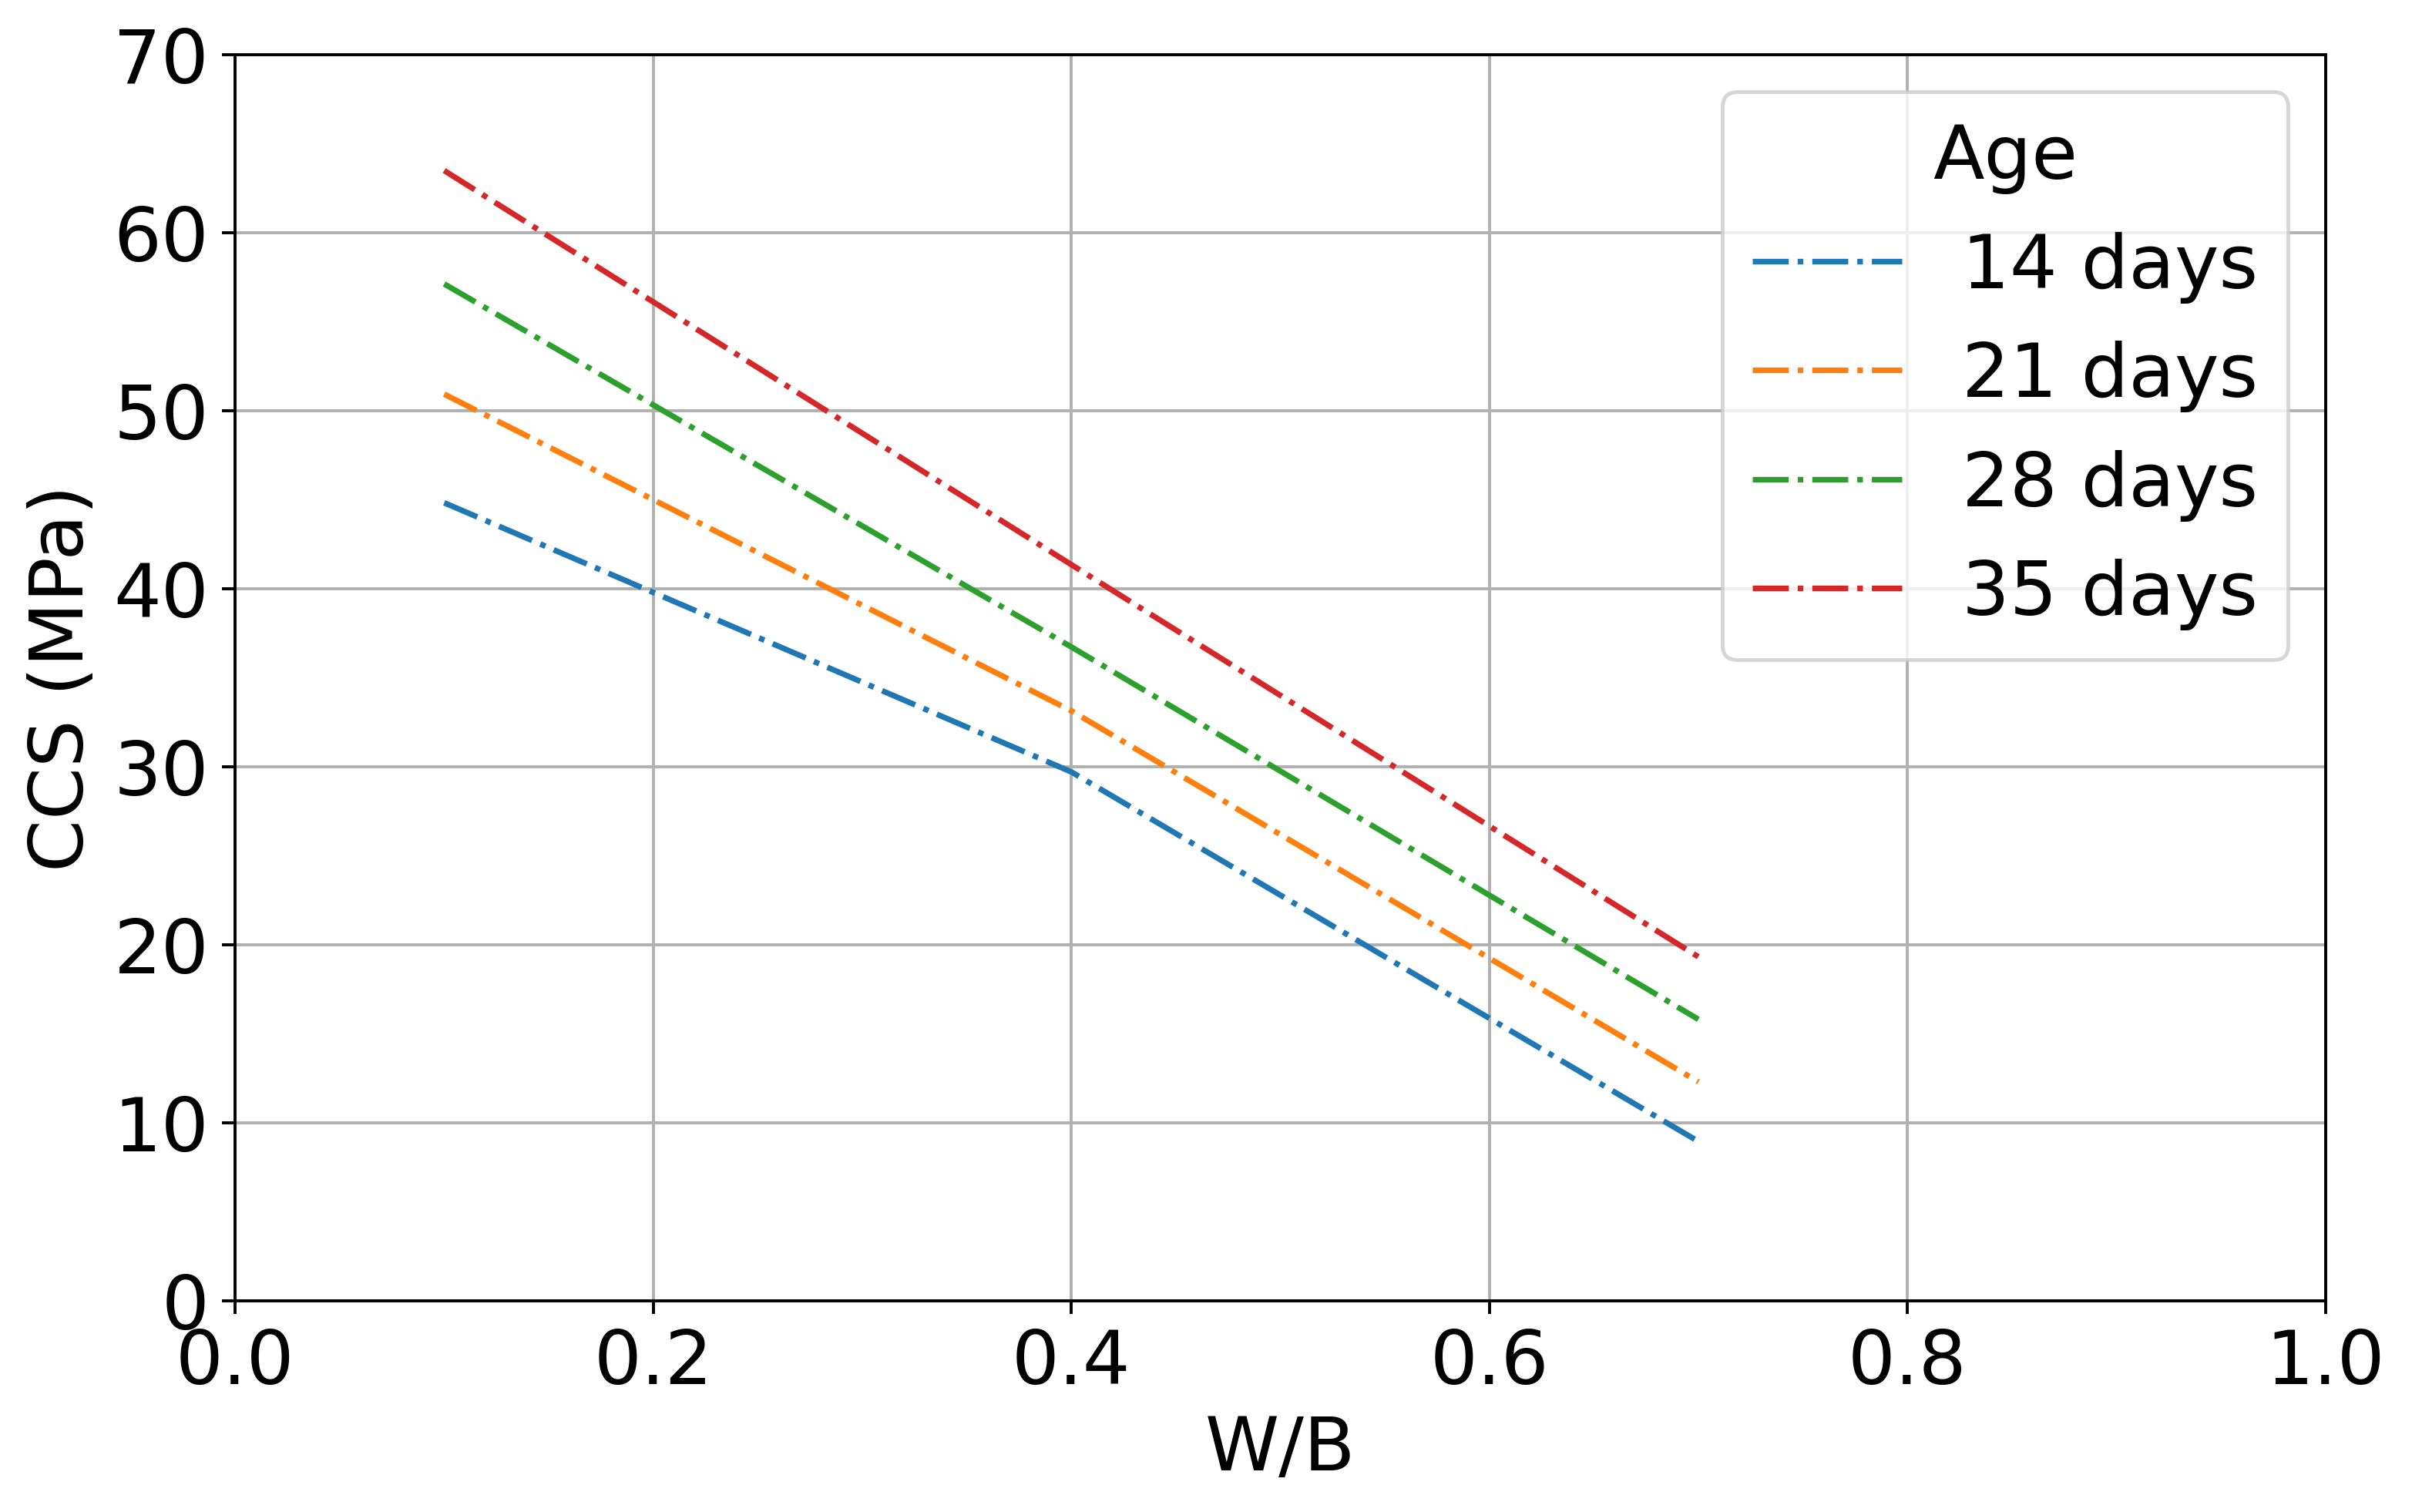

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# New relations based on BFS/B = 20%, FA/B = 20%, CA/FA = 1.20
total_binder = 407.64  # Total Binder value

# Calculating the values for BFS/B and FA/B
blast_furnace_slag = 0.20 * total_binder  # BFS/B = 20% of Total Binder
fly_ash = 0.20 * total_binder  # FA/B = 20% of Total Binder

# Fixed values for the rest of the parameters
cement = total_binder - (blast_furnace_slag + fly_ash)  # Cement content after BFS and FA
coarse_aggregate = 974.81  # CA/FA = 1.20 (Fixed value)
fine_aggregate = coarse_aggregate / 1.20  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 2.00  # Superplasticizer = 0.00

# Water-to-Binder Ratios to test
w_b_ratios = np.linspace(0.1, 0.7, 3)  # Example range of W/B ratio from 0.1 to 1.0

# List of ages to test
ages = [14, 21, 28, 35]  # Age values to test

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over each age to generate the CCS predictions
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each W/B ratio at the current age
    for w_b in w_b_ratios:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(w_b_ratios, predictions, label=f'{age} days',linestyle='dashdot')

# Adding labels and title
plt.xlabel("W/B",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 70)
plt.tick_params(axis='both', labelsize=20)
# plt.title("Concrete Compressive Strength vs. Water-to-Binder Ratio for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.grid(True)
plt.show()


# Plot 4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

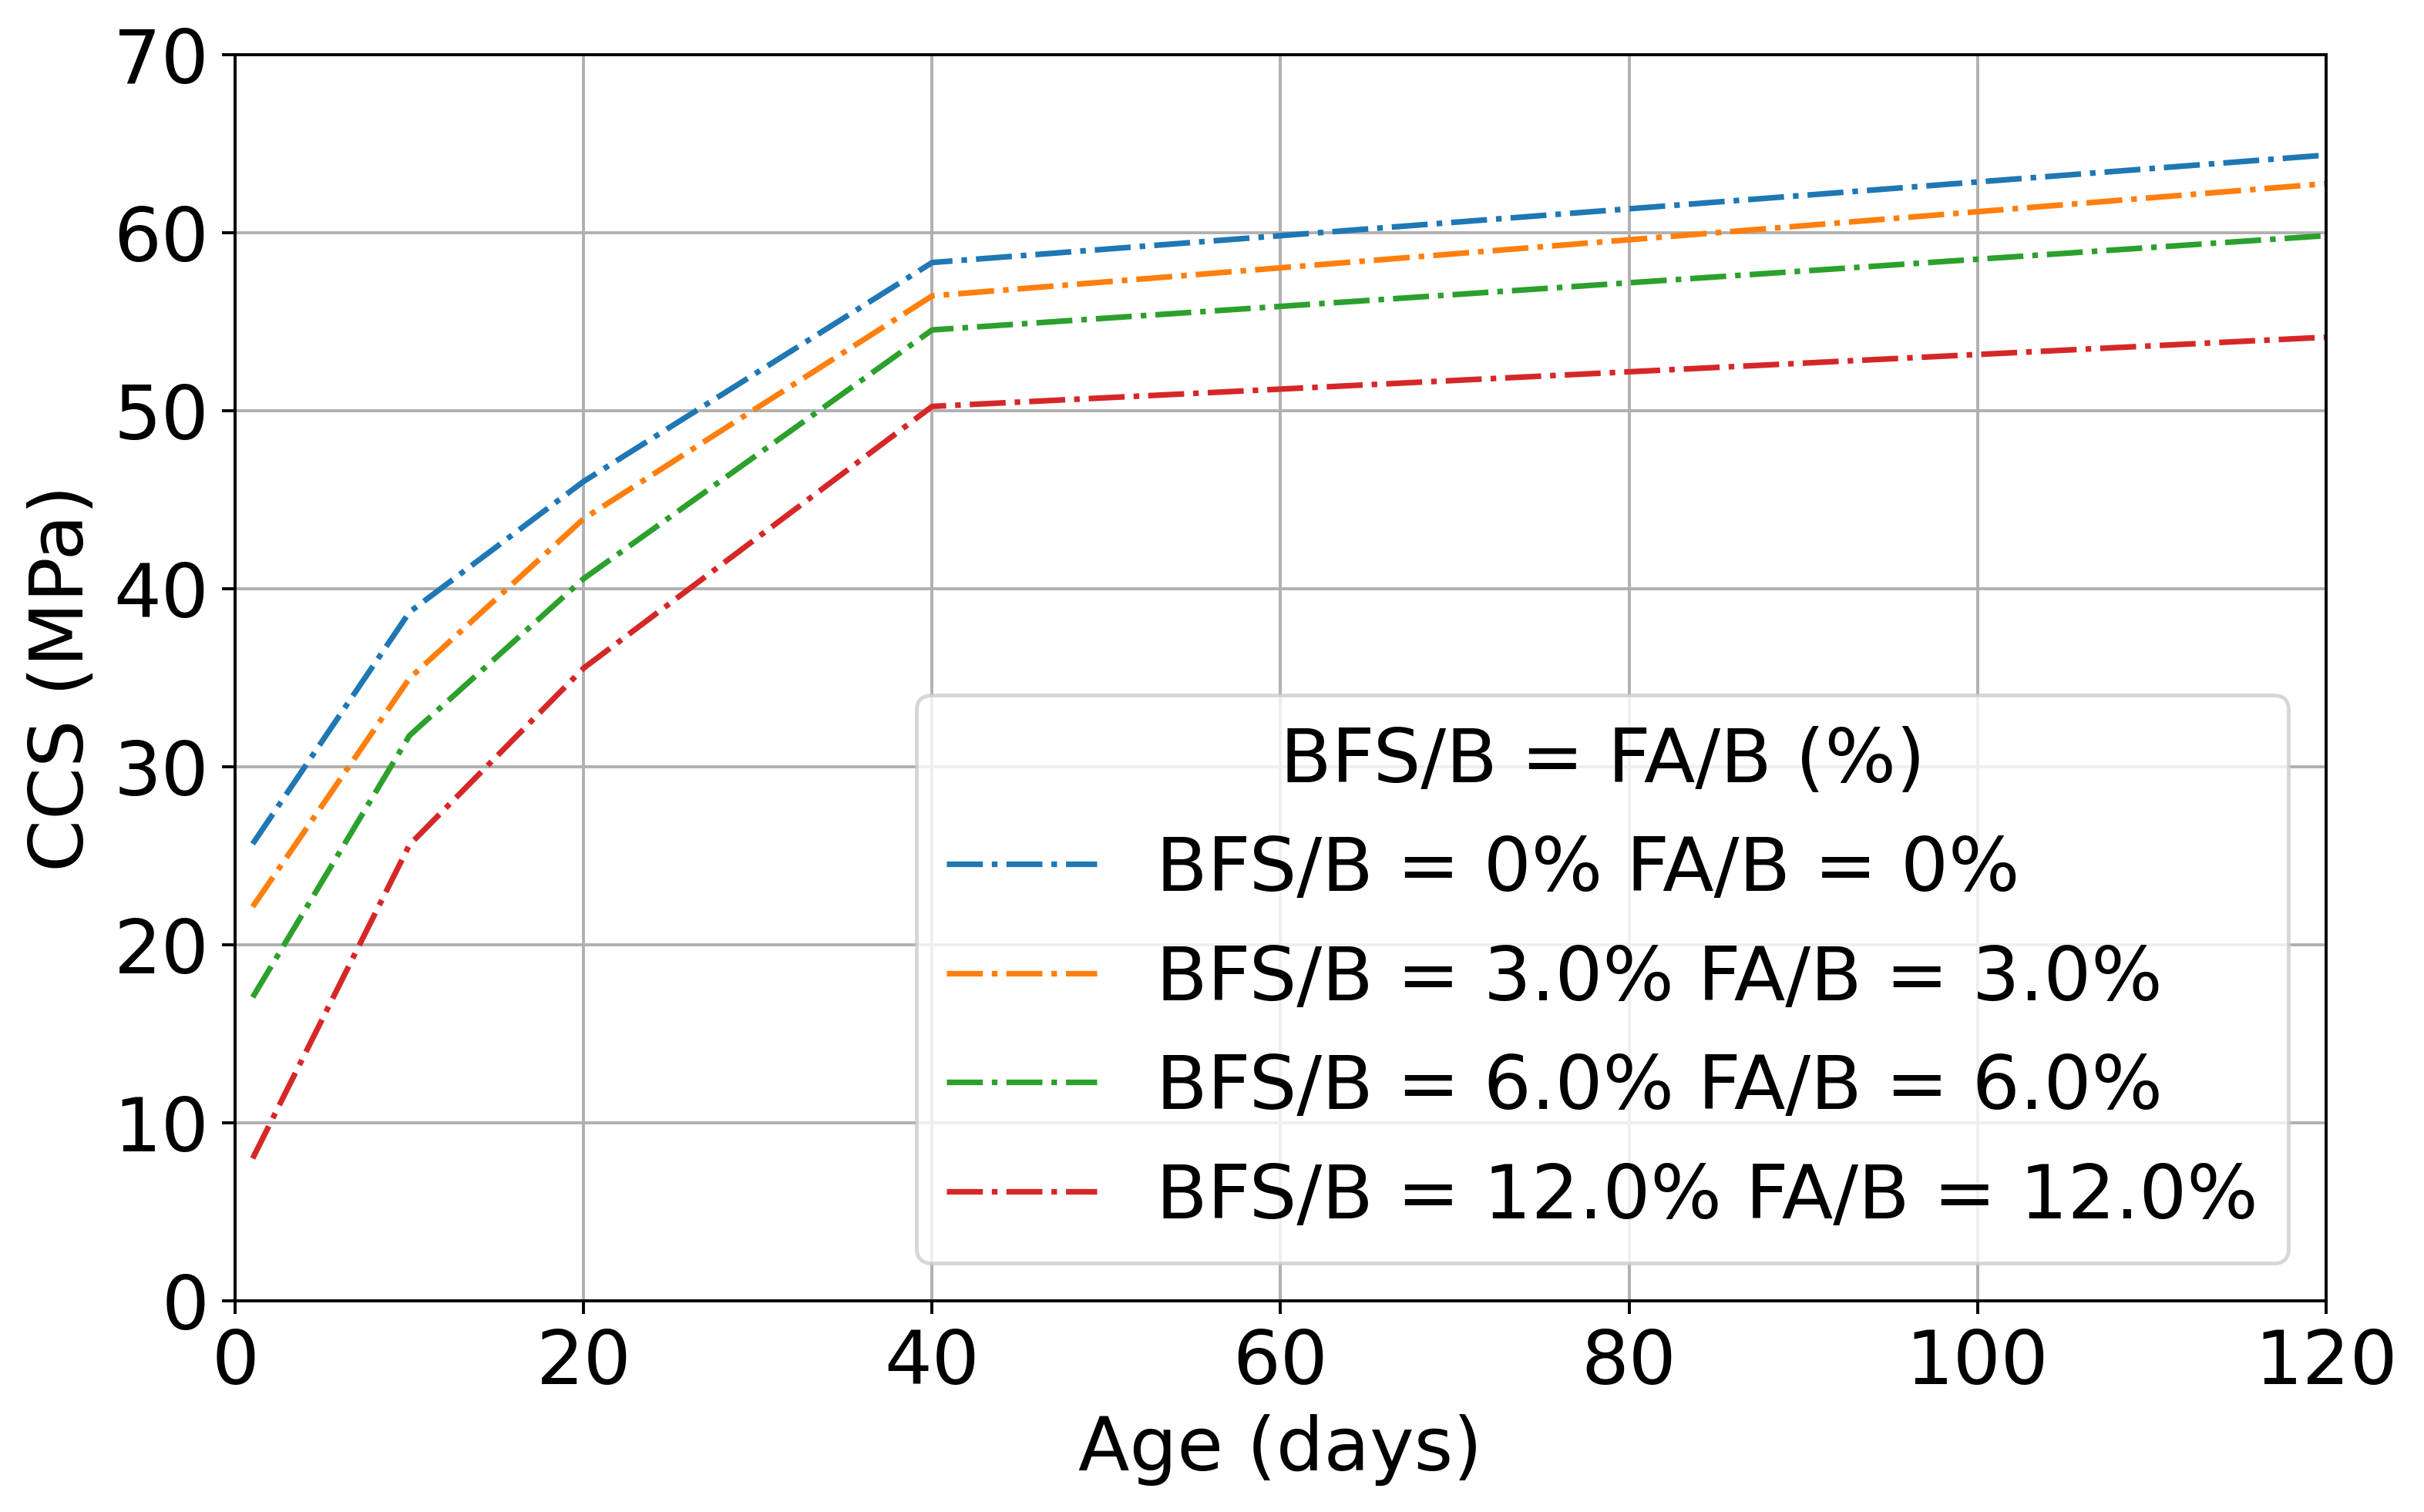

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
cement = total_binder  # Cement value will be adjusted based on BFS and FA percentages
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 0  # Superplasticizer = 0.00
w_b_ratio = 0.3  # Fixed Water-to-Binder Ratio

# List of ages to test
# ages = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91])  # Age values from 7 to 91 days
ages = np.array([1,10,20, 40, 120])

# BFS/B and FA/B percentages to vary from 0% to 30%
bfs_b_percentages = [0,0.03,0.06,0.12]  # BFS/B varies from 0% to 30%
fa_b_percentages = [0,0.03,0.06,0.12]  # FA/B varies from 0% to 30%

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over different BFS/B and FA/B percentages
for bfs_b in bfs_b_percentages:
    for fa_b in fa_b_percentages:
      if fa_b == bfs_b:
        predictions = []  # Reset predictions for the current BFS/B and FA/B

        # Calculate BFS and FA based on their percentages
        blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
        fly_ash = fa_b * total_binder  # FA/B = percentage of Total Binder

        # Adjust cement based on BFS and FA content
        cement = total_binder - (blast_furnace_slag + fly_ash)

        # Generate predictions for each age
        for age in ages:
            # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
            water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

            # Create the feature vector (Input features to the model)
            input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                        coarse_aggregate, fine_aggregate, age]])

            # Scale the input features using the pre-trained scaler
            input_scaled = scaler_X.transform(input_features)

            # Convert input to a torch tensor and predict the Concrete Compressive Strength
            input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            # Forward prediction: Concrete Compressive Strength (CCS)
            forward_pred, _ = model(input_tensor)

            # Inverse transform the output (predicted CCS)
            predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

            # Store the prediction
            predictions.append(predicted_strength[0][0])

        # Plot the results for the current BFS/B and FA/B
        plt.plot(ages, predictions, label=f'BFS/B = {bfs_b*100}% FA/B = {fa_b*100}%',linestyle='dashdot')

# Adding labels and title
plt.xlabel("Age (days)",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 120)
plt.ylim(0, 70)
# plt.title("Concrete Compressive Strength vs. Age for Different BFS/B and FA/B Ratios")
plt.legend(title="BFS/B = FA/B (%)",fontsize=20,title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)

plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

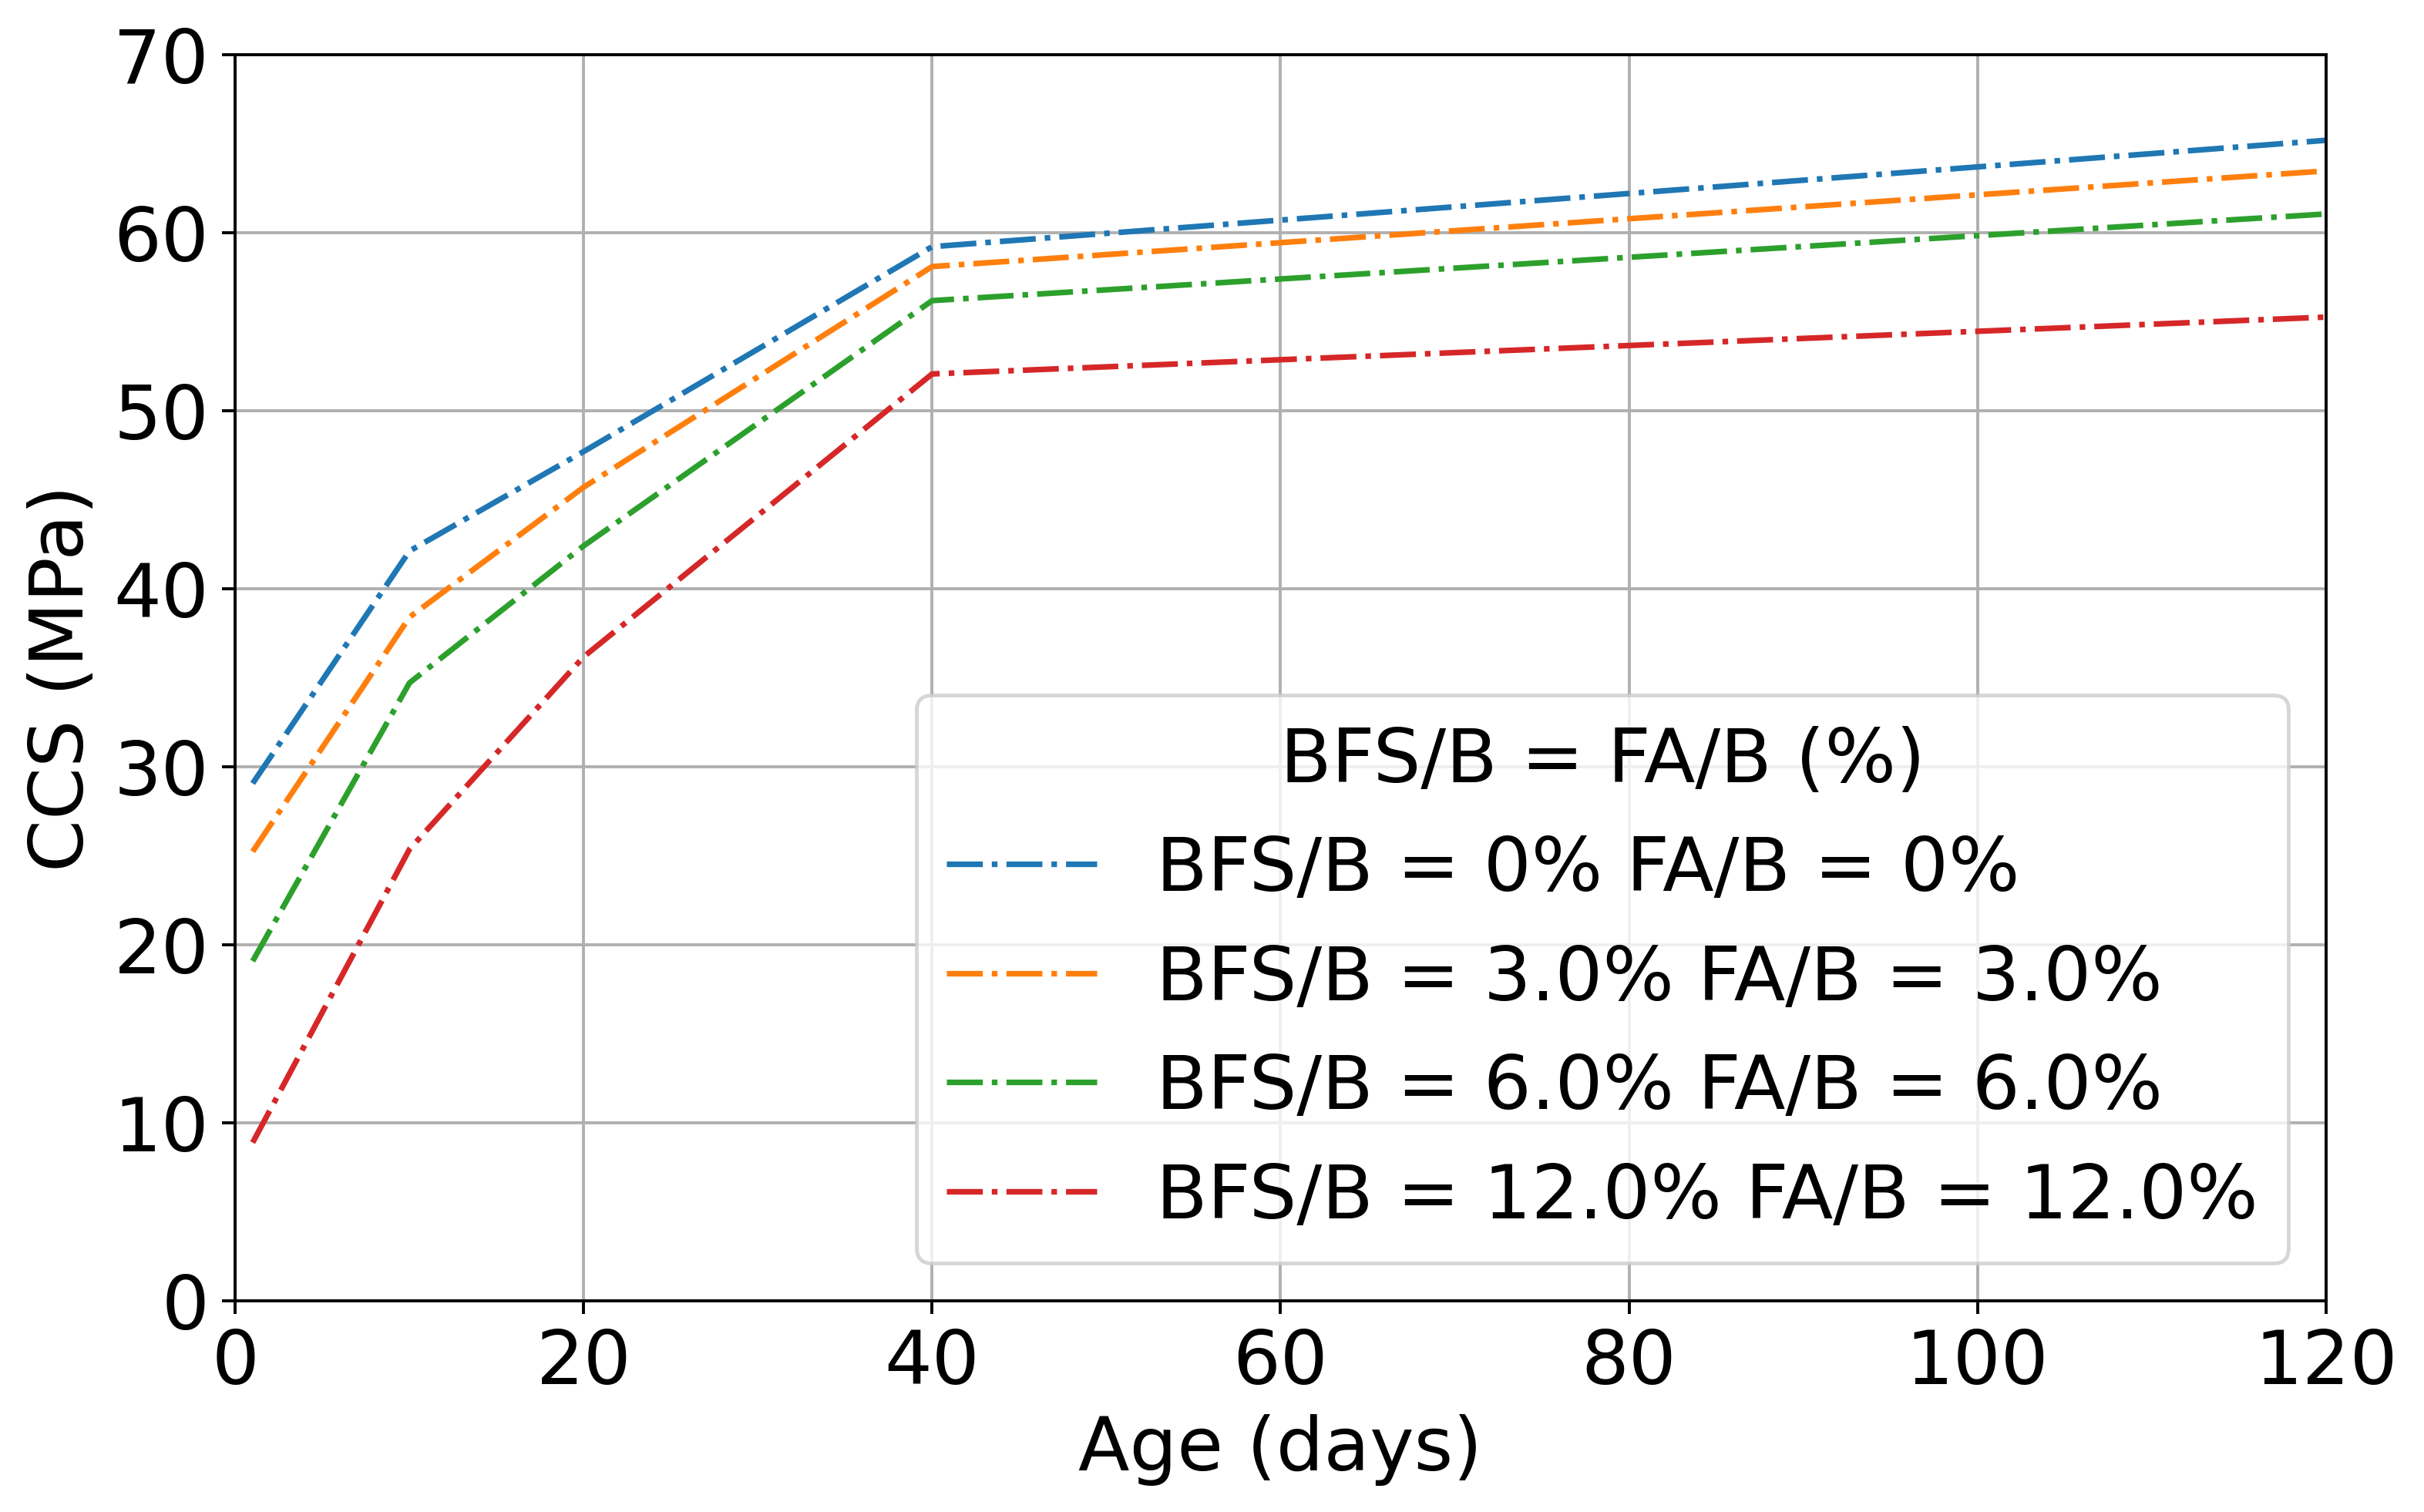

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
cement = total_binder  # Cement value will be adjusted based on BFS and FA percentages
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 1.50  # Superplasticizer = 0.00
w_b_ratio = 0.3  # Fixed Water-to-Binder Ratio

# List of ages to test
# ages = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91])  # Age values from 7 to 91 days
ages = np.array([1,10,20, 40, 120])

# BFS/B and FA/B percentages to vary from 0% to 30%
bfs_b_percentages = [0,0.03,0.06,0.12]  # BFS/B varies from 0% to 30%
fa_b_percentages = [0,0.03,0.06,0.12]  # FA/B varies from 0% to 30%

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over different BFS/B and FA/B percentages
for bfs_b in bfs_b_percentages:
    for fa_b in fa_b_percentages:
      if fa_b == bfs_b:
        predictions = []  # Reset predictions for the current BFS/B and FA/B

        # Calculate BFS and FA based on their percentages
        blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
        fly_ash = fa_b * total_binder  # FA/B = percentage of Total Binder

        # Adjust cement based on BFS and FA content
        cement = total_binder - (blast_furnace_slag + fly_ash)

        # Generate predictions for each age
        for age in ages:
            # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
            water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

            # Create the feature vector (Input features to the model)
            input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                        coarse_aggregate, fine_aggregate, age]])

            # Scale the input features using the pre-trained scaler
            input_scaled = scaler_X.transform(input_features)

            # Convert input to a torch tensor and predict the Concrete Compressive Strength
            input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            # Forward prediction: Concrete Compressive Strength (CCS)
            forward_pred, _ = model(input_tensor)

            # Inverse transform the output (predicted CCS)
            predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

            # Store the prediction
            predictions.append(predicted_strength[0][0])

        # Plot the results for the current BFS/B and FA/B
        plt.plot(ages, predictions, label=f'BFS/B = {bfs_b*100}% FA/B = {fa_b*100}%',linestyle='dashdot')

# Adding labels and title
plt.xlabel("Age (days)",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
plt.xlim(0, 120)
plt.ylim(0, 70)
# plt.title("Concrete Compressive Strength vs. Age for Different BFS/B and FA/B Ratios")
plt.legend(title="BFS/B = FA/B (%)",fontsize=20,title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)

plt.grid(True)
plt.show()


# plot 5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

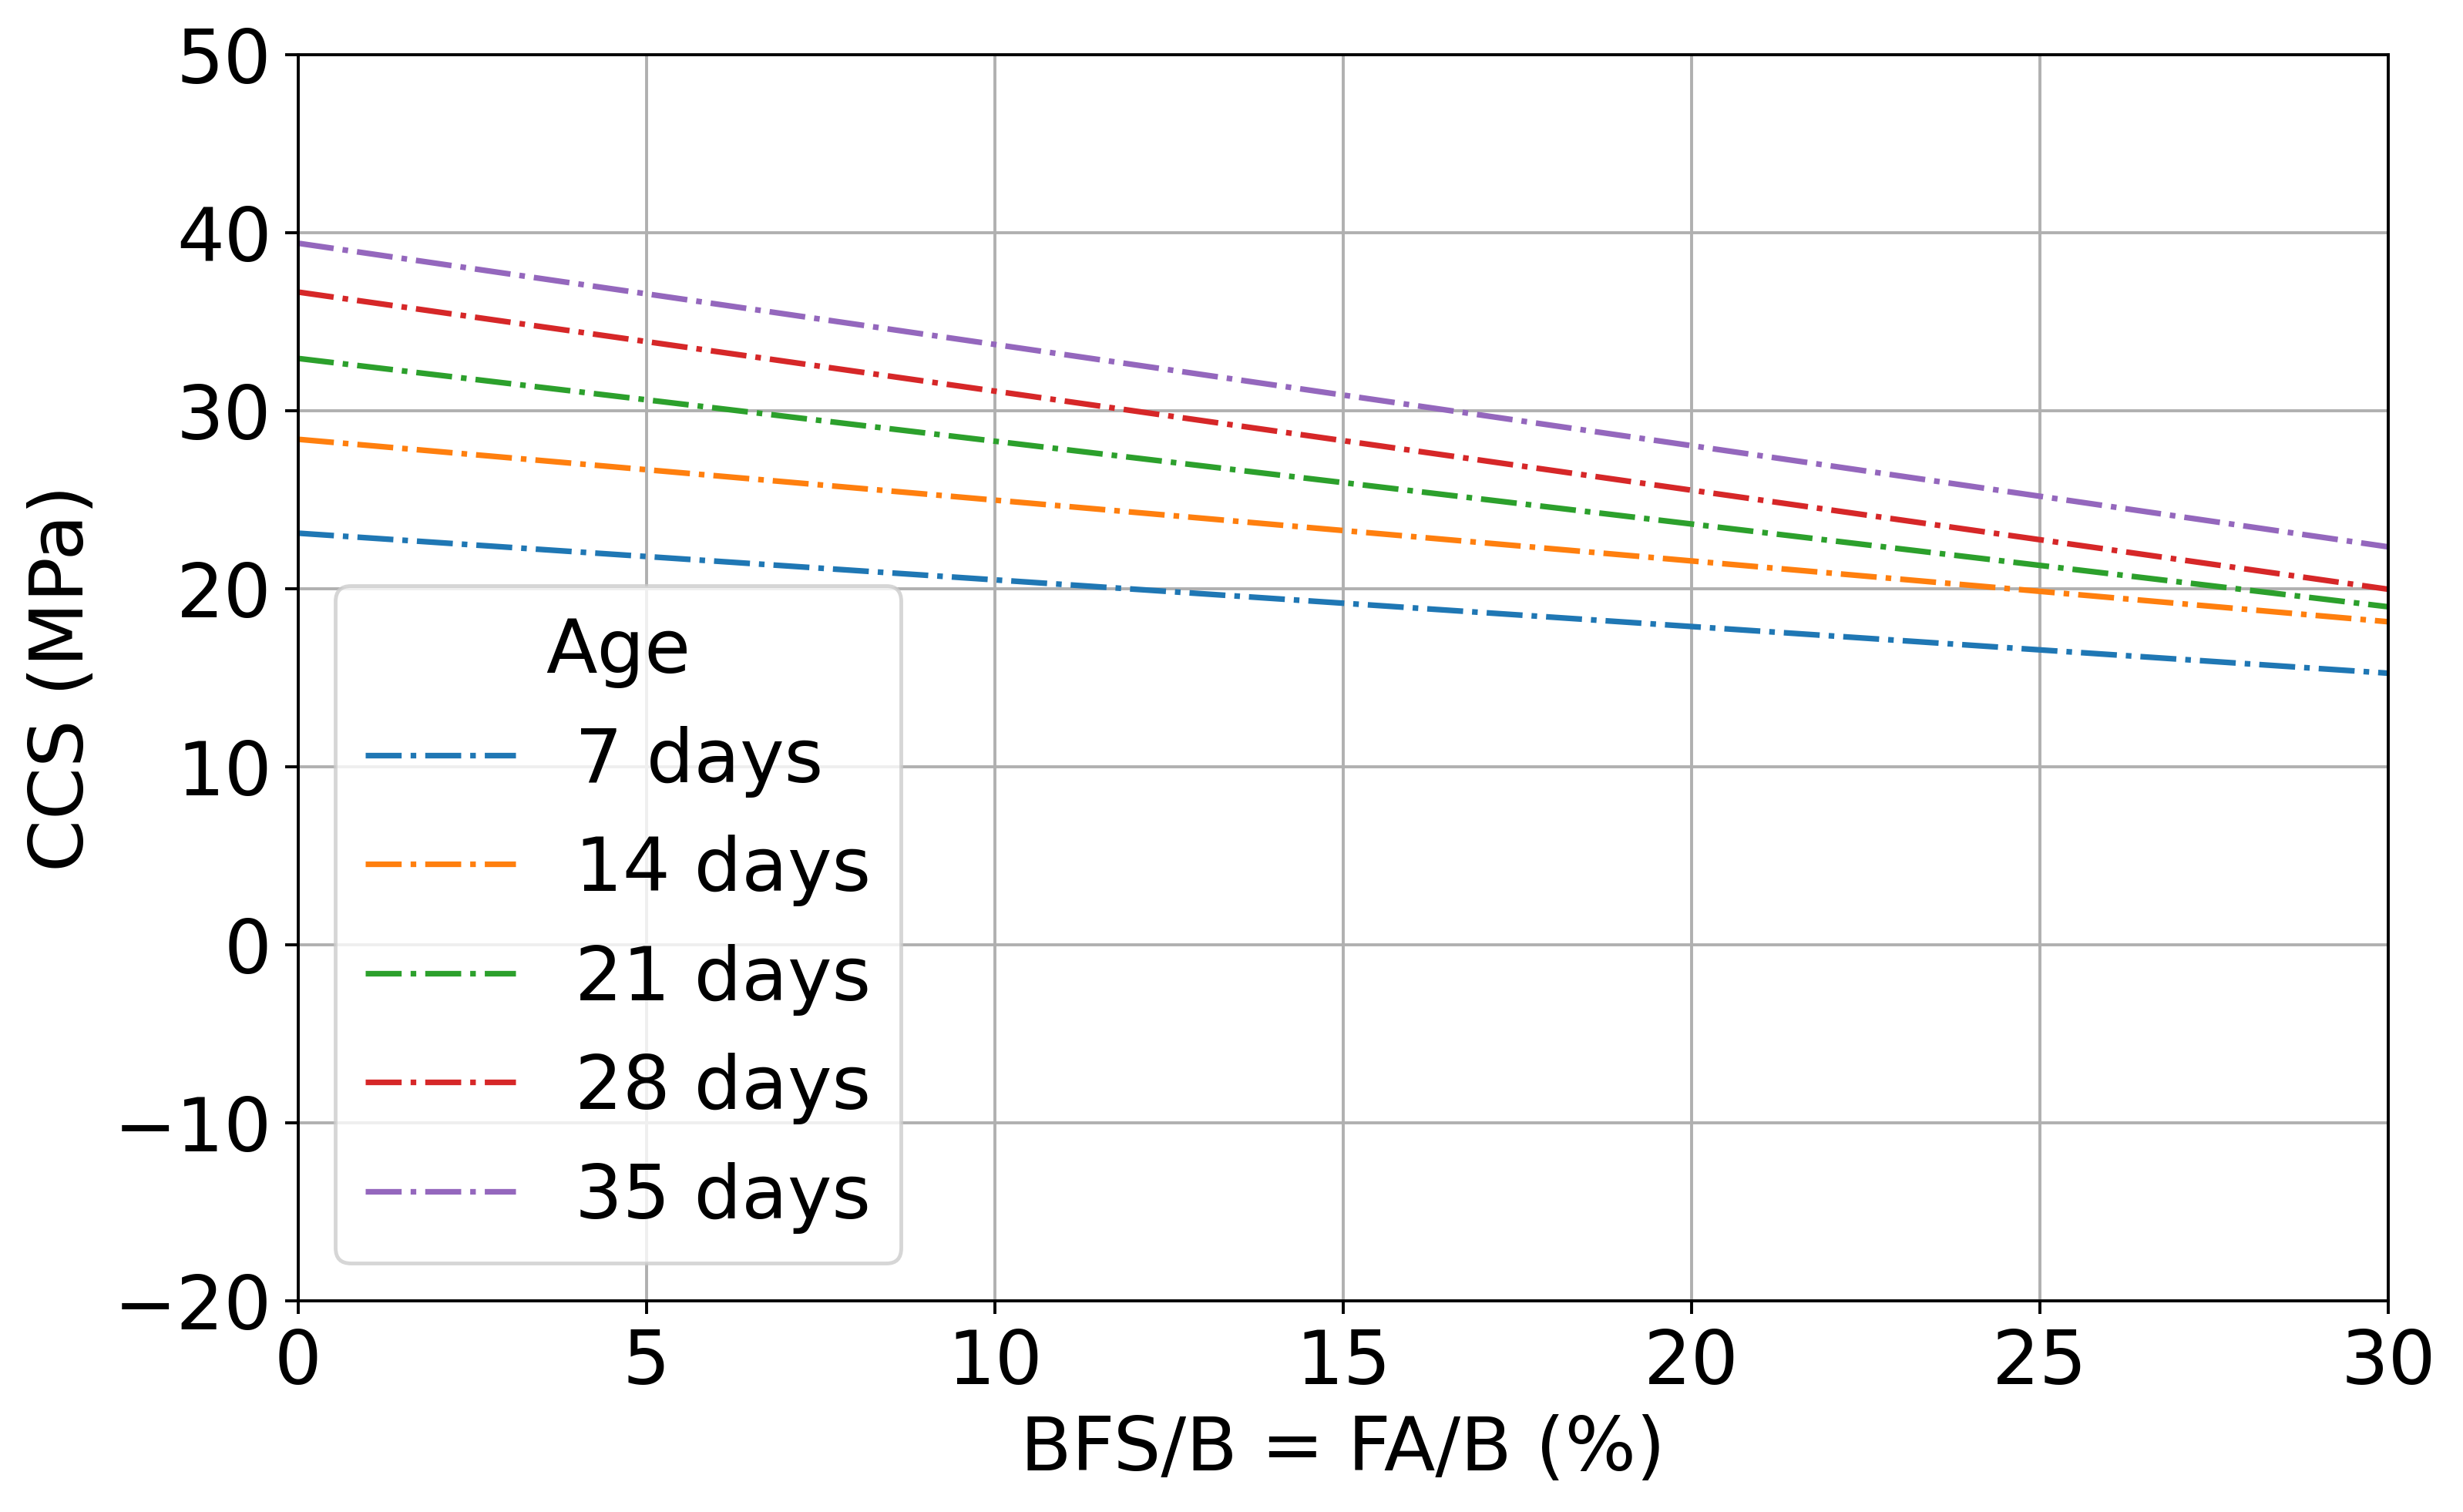

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
cement = total_binder  # Cement value will be adjusted based on BFS and FA percentages
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 0  # Superplasticizer = 0.00
w_b_ratio = 0.5  # Fixed Water-to-Binder Ratio

# List of ages to test
ages = np.array([7, 14, 21, 28, 35,])  # Age values from 7 to 91 days

# BFS/B and FA/B percentages to vary (since BFS/B = FA/B, we will vary one of them)
bfs_b_percentages = np.linspace(0, 0.30, 2)  # BFS/B varies from 0% to 30%

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)


# Loop over different BFS/B (which is the same as FA/B)
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each BFS/B value at the current age
    for bfs_b in bfs_b_percentages:
        # Calculate BFS and FA based on their percentages
        blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
        fly_ash = bfs_b * total_binder  # FA/B = percentage of Total Binder

        # Adjust cement based on BFS and FA content
        cement = total_binder - (blast_furnace_slag + fly_ash)

        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(bfs_b_percentages * 100, predictions, linestyle='dashdot',label=f'{age} days')

# Adding labels and title
plt.xlabel("BFS/B = FA/B (%)",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
# plt.title("Concrete Compressive Strength vs. BFS/B (FA/B) for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.ylim(-20,50)
plt.xlim(0,30)

plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

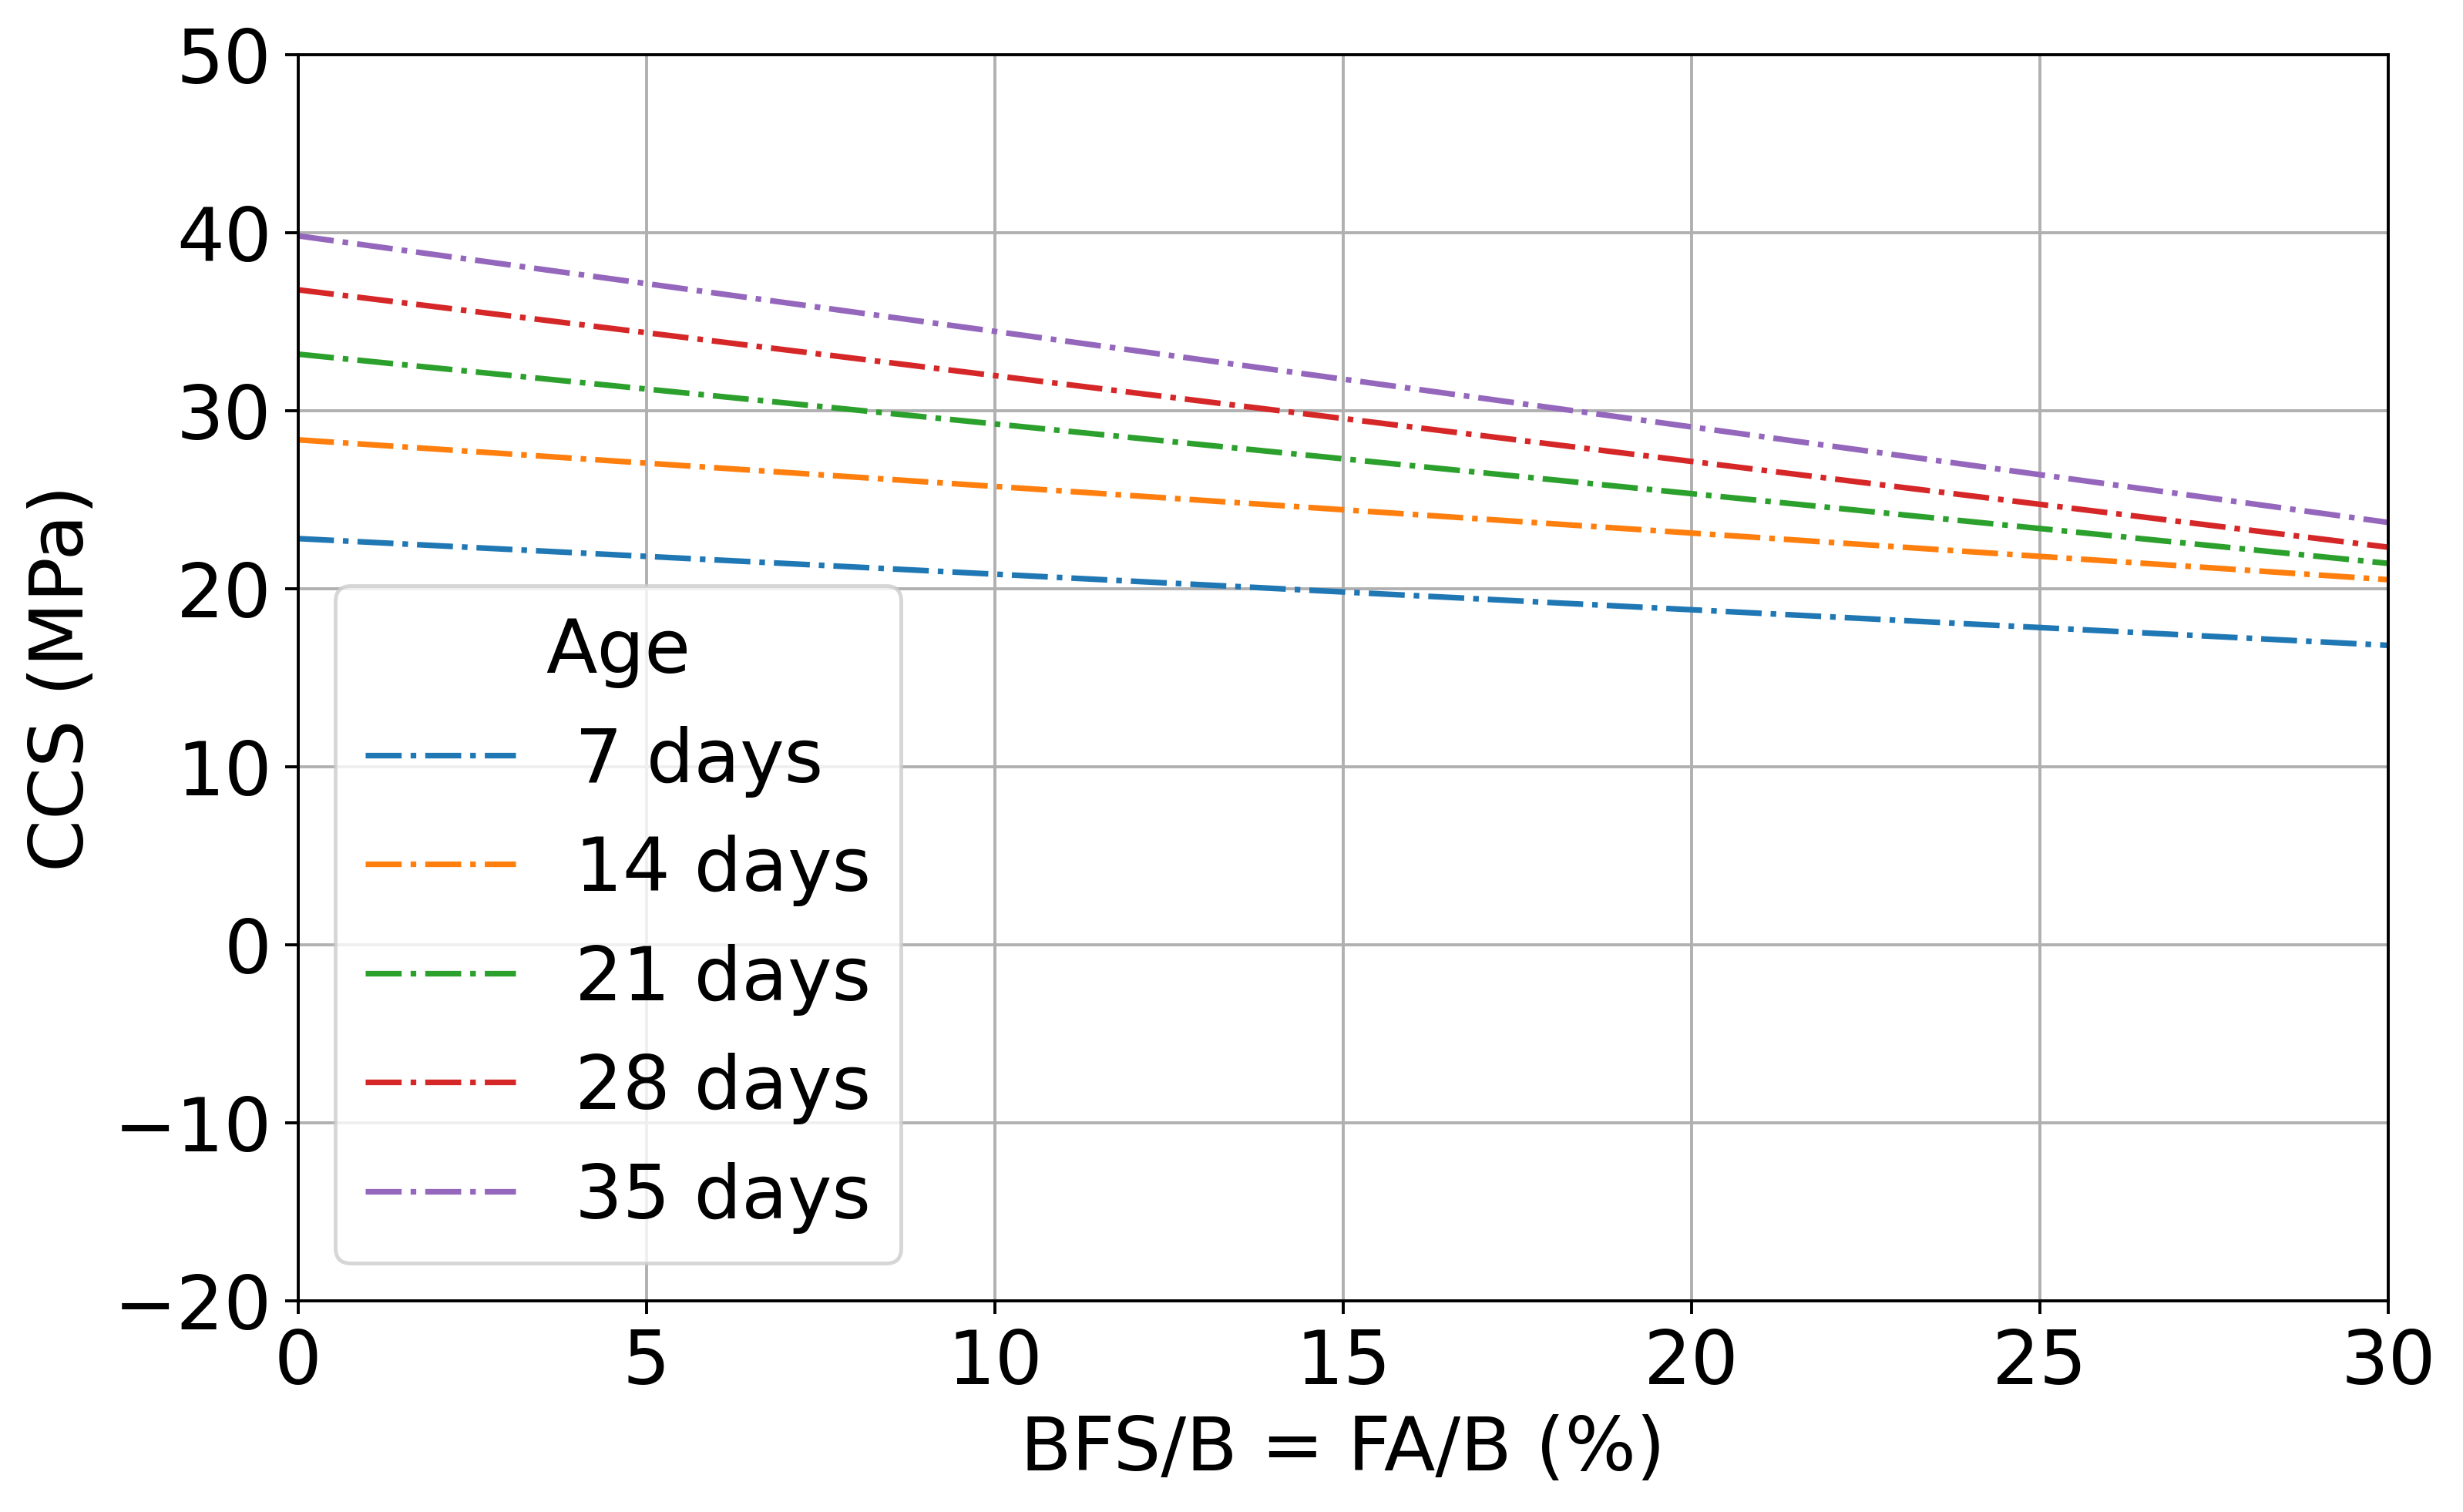

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
cement = total_binder  # Cement value will be adjusted based on BFS and FA percentages
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
superplasticizer_percentage = 1.5  # Superplasticizer = 0.00
w_b_ratio = 0.5  # Fixed Water-to-Binder Ratio

# List of ages to test
ages = np.array([7, 14, 21, 28, 35,])  # Age values from 7 to 91 days

# BFS/B and FA/B percentages to vary (since BFS/B = FA/B, we will vary one of them)
bfs_b_percentages = np.linspace(0, 0.30, 2)  # BFS/B varies from 0% to 30%

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)


# Loop over different BFS/B (which is the same as FA/B)
for age in ages:
    predictions = []  # Reset predictions for the current age

    # Generate predictions for each BFS/B value at the current age
    for bfs_b in bfs_b_percentages:
        # Calculate BFS and FA based on their percentages
        blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
        fly_ash = bfs_b * total_binder  # FA/B = percentage of Total Binder

        # Adjust cement based on BFS and FA content
        cement = total_binder - (blast_furnace_slag + fly_ash)

        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current age
    plt.plot(bfs_b_percentages * 100, predictions, linestyle='dashdot',label=f'{age} days')

# Adding labels and title
plt.xlabel("BFS/B = FA/B (%)",fontsize=20)
plt.ylabel("CCS (MPa)",fontsize=20)
# plt.title("Concrete Compressive Strength vs. BFS/B (FA/B) for Various Ages")
plt.legend(title="Age",fontsize=20,title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.ylim(-20,50)
plt.xlim(0,30)

plt.grid(True)
plt.show()


# Plot 6

superplasticizer percentage from 0 to 20 and plot multiple lines for BFS/B = 0, you need to:

Fix BFS/B = 0 and keep FA/B = BFS/B for the corresponding values.
Vary the superplasticizer percentage from 0% to 20% for BFS/B = 0.
Plot the results for each superplasticizer percentage while keeping BFS/B constant.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

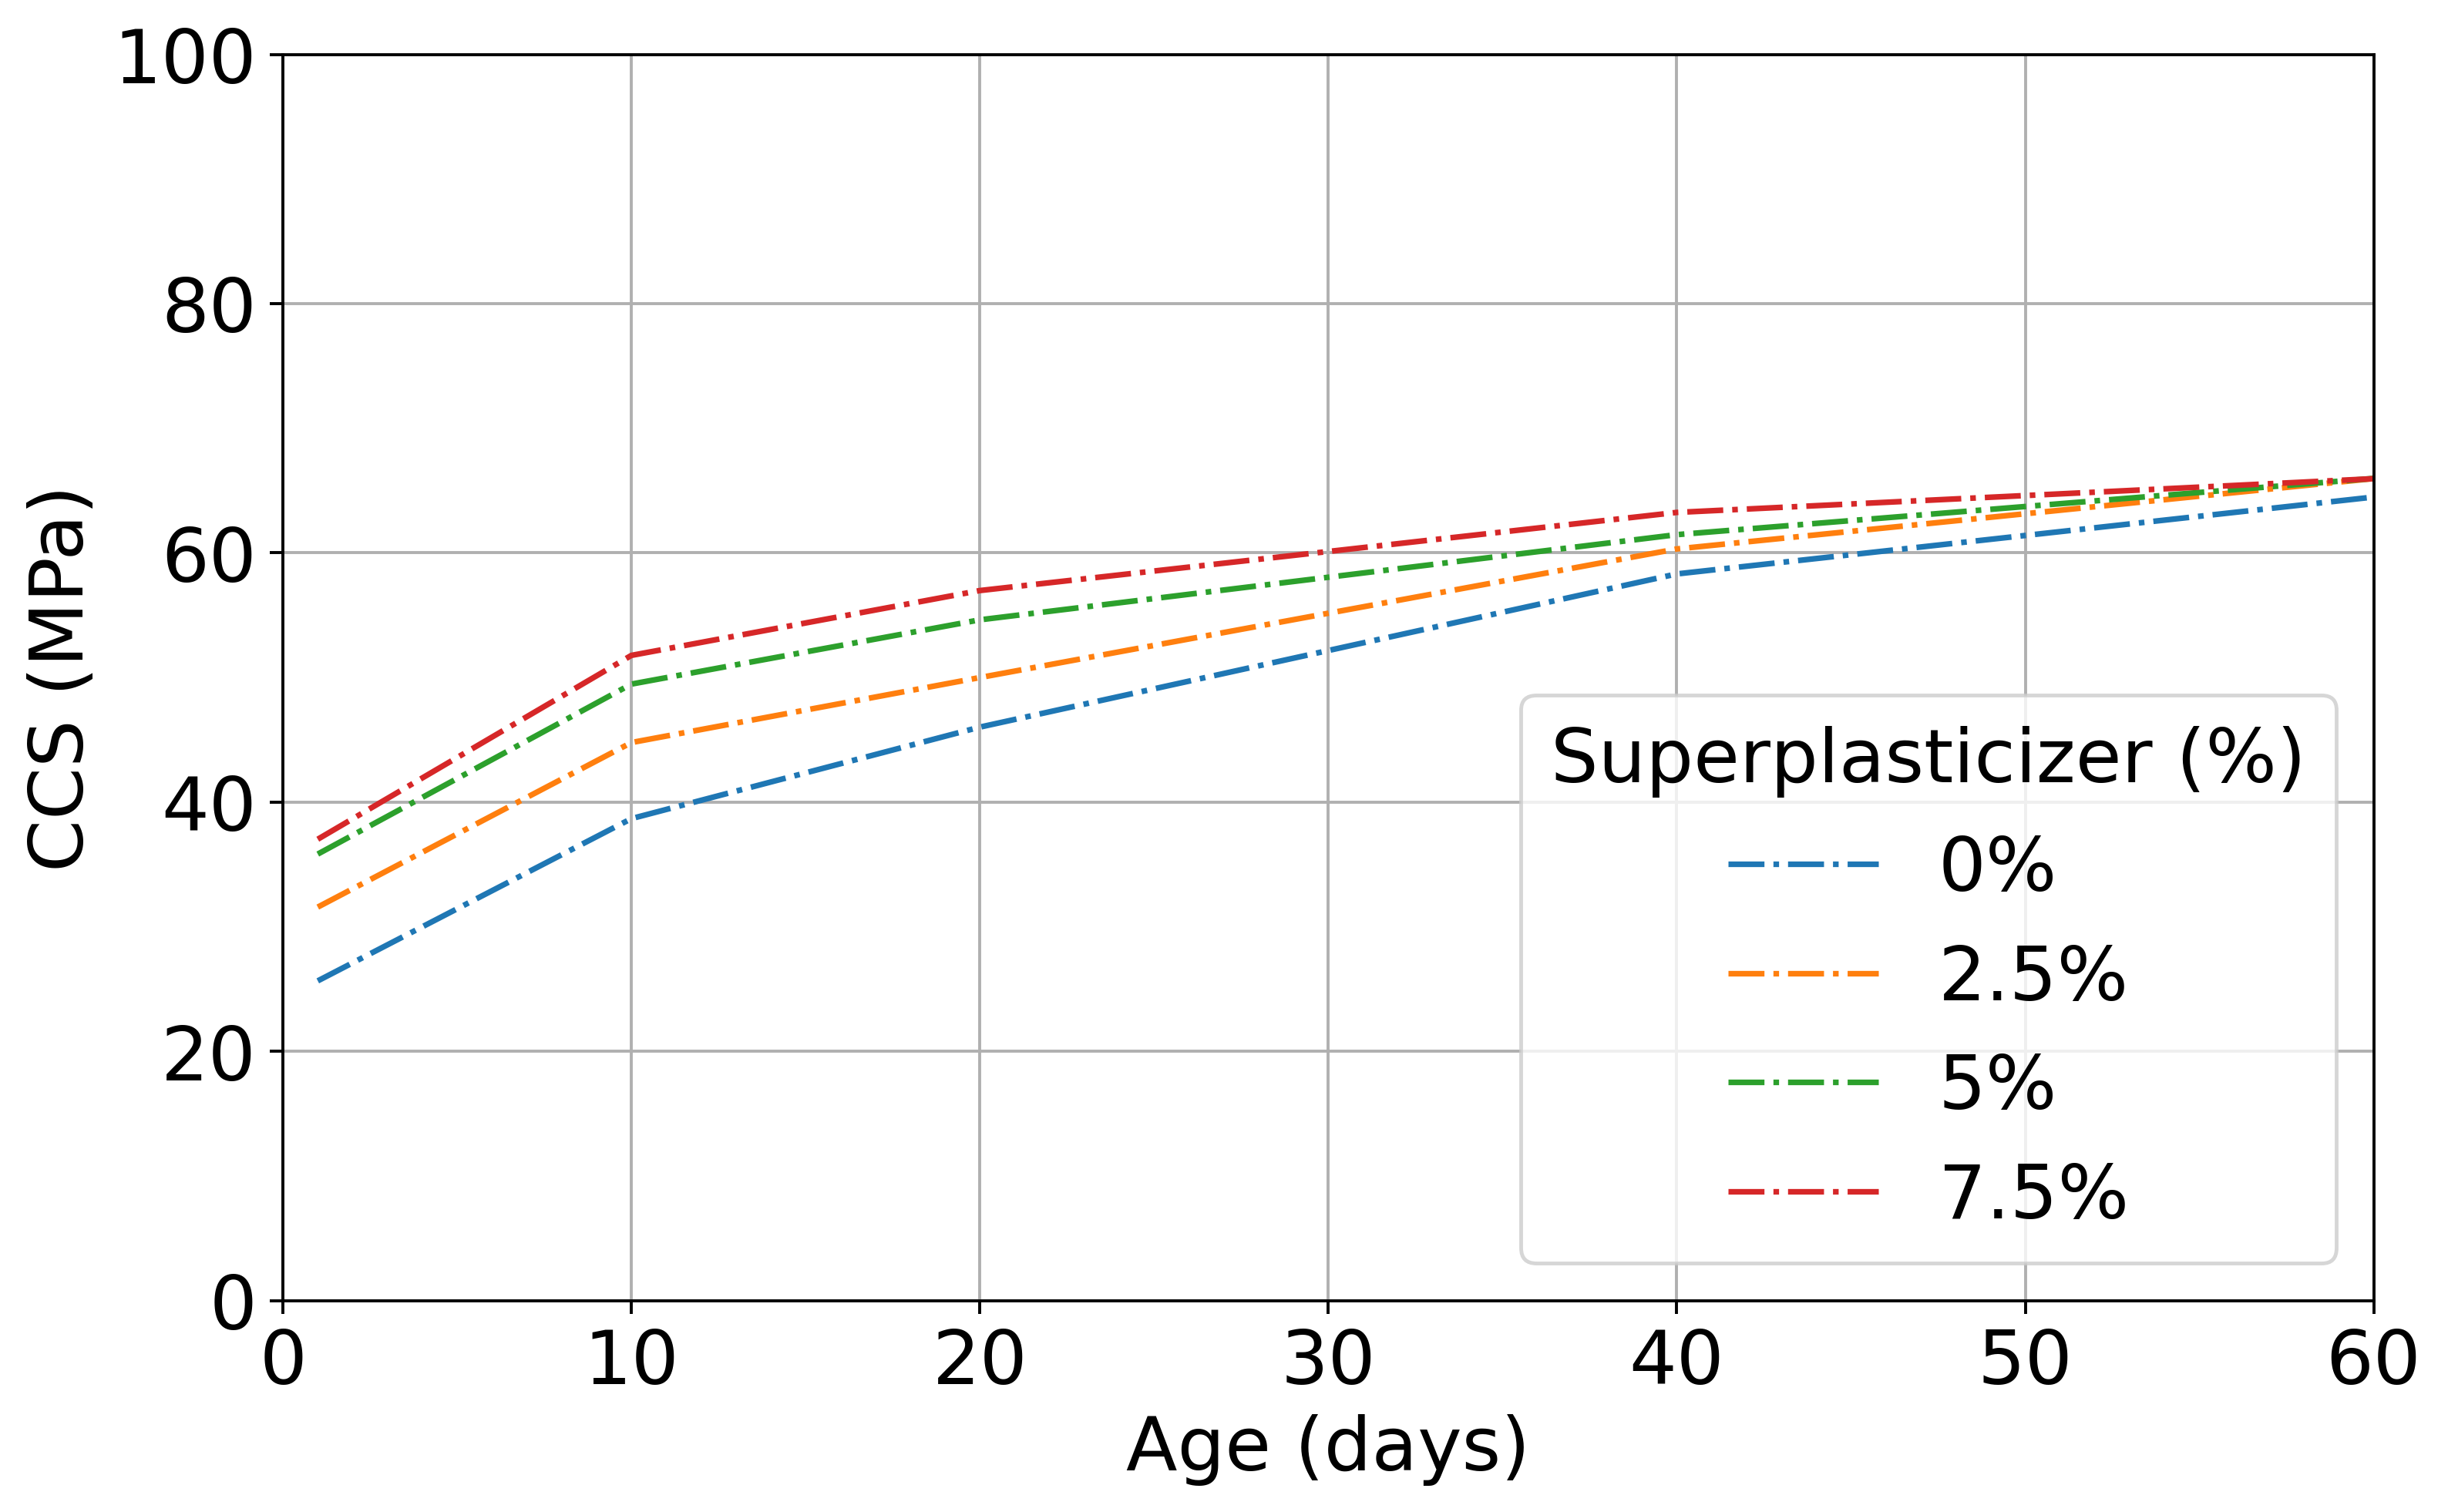

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
w_b_ratio = 0.3  # Fixed Water-to-Binder Ratio

# List of ages to test
ages = np.array([1, 10, 20, 40, 80])  # Age values from 1 day to 120 days

# BFS/B and FA/B percentages to vary from 0% to 30%
bfs_b = 0  # BFS/B = 0 for this plot
fa_b = bfs_b  # FA/B = BFS/B (same for this case)

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over different superplasticizer percentages from 0 to 20
superplasticizer_percentages = [0,2.5,5,7.5]  # Superplasticizer from 0% to 20%

# Generate predictions for each superplasticizer percentage at BFS/B = 0 and FA/B = 0
for superplasticizer_percentage in superplasticizer_percentages:
    predictions = []  # Reset predictions for the current superplasticizer percentage

    # Calculate BFS and FA based on their percentages
    blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
    fly_ash = fa_b * total_binder  # FA/B = percentage of Total Binder

    # Adjust cement based on BFS and FA content
    cement = total_binder - (blast_furnace_slag + fly_ash)

    # Generate predictions for each age
    for age in ages:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, superplasticizer_percentage,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current superplasticizer percentage
    plt.plot(ages, predictions, label=f'{superplasticizer_percentage}%',linestyle='dashdot')

# Adding labels and title
plt.xlabel("Age (days)", fontsize=20)
plt.ylabel("CCS (MPa)", fontsize=20)
plt.xlim(0, 60)
plt.ylim(0, 100)
# plt.title("Concrete Compressive Strength vs. Age for Different Superplasticizer Percentages")
plt.legend(title="Superplasticizer (%)", fontsize=20, title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)

plt.grid(True)
plt.show()


This code will generate a plot showing multiple lines for different superplasticizer percentages (from 0% to 20%) at different ages (1, 10, 20, 40, and 120 days) for BFS/B = 12%. The x-axis will represent age in days, and the y-axis will represent the Concrete Compressive Strength (CCS) in MPa. Each line will show how the CCS varies with age for a particular superplasticizer percentage.






/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

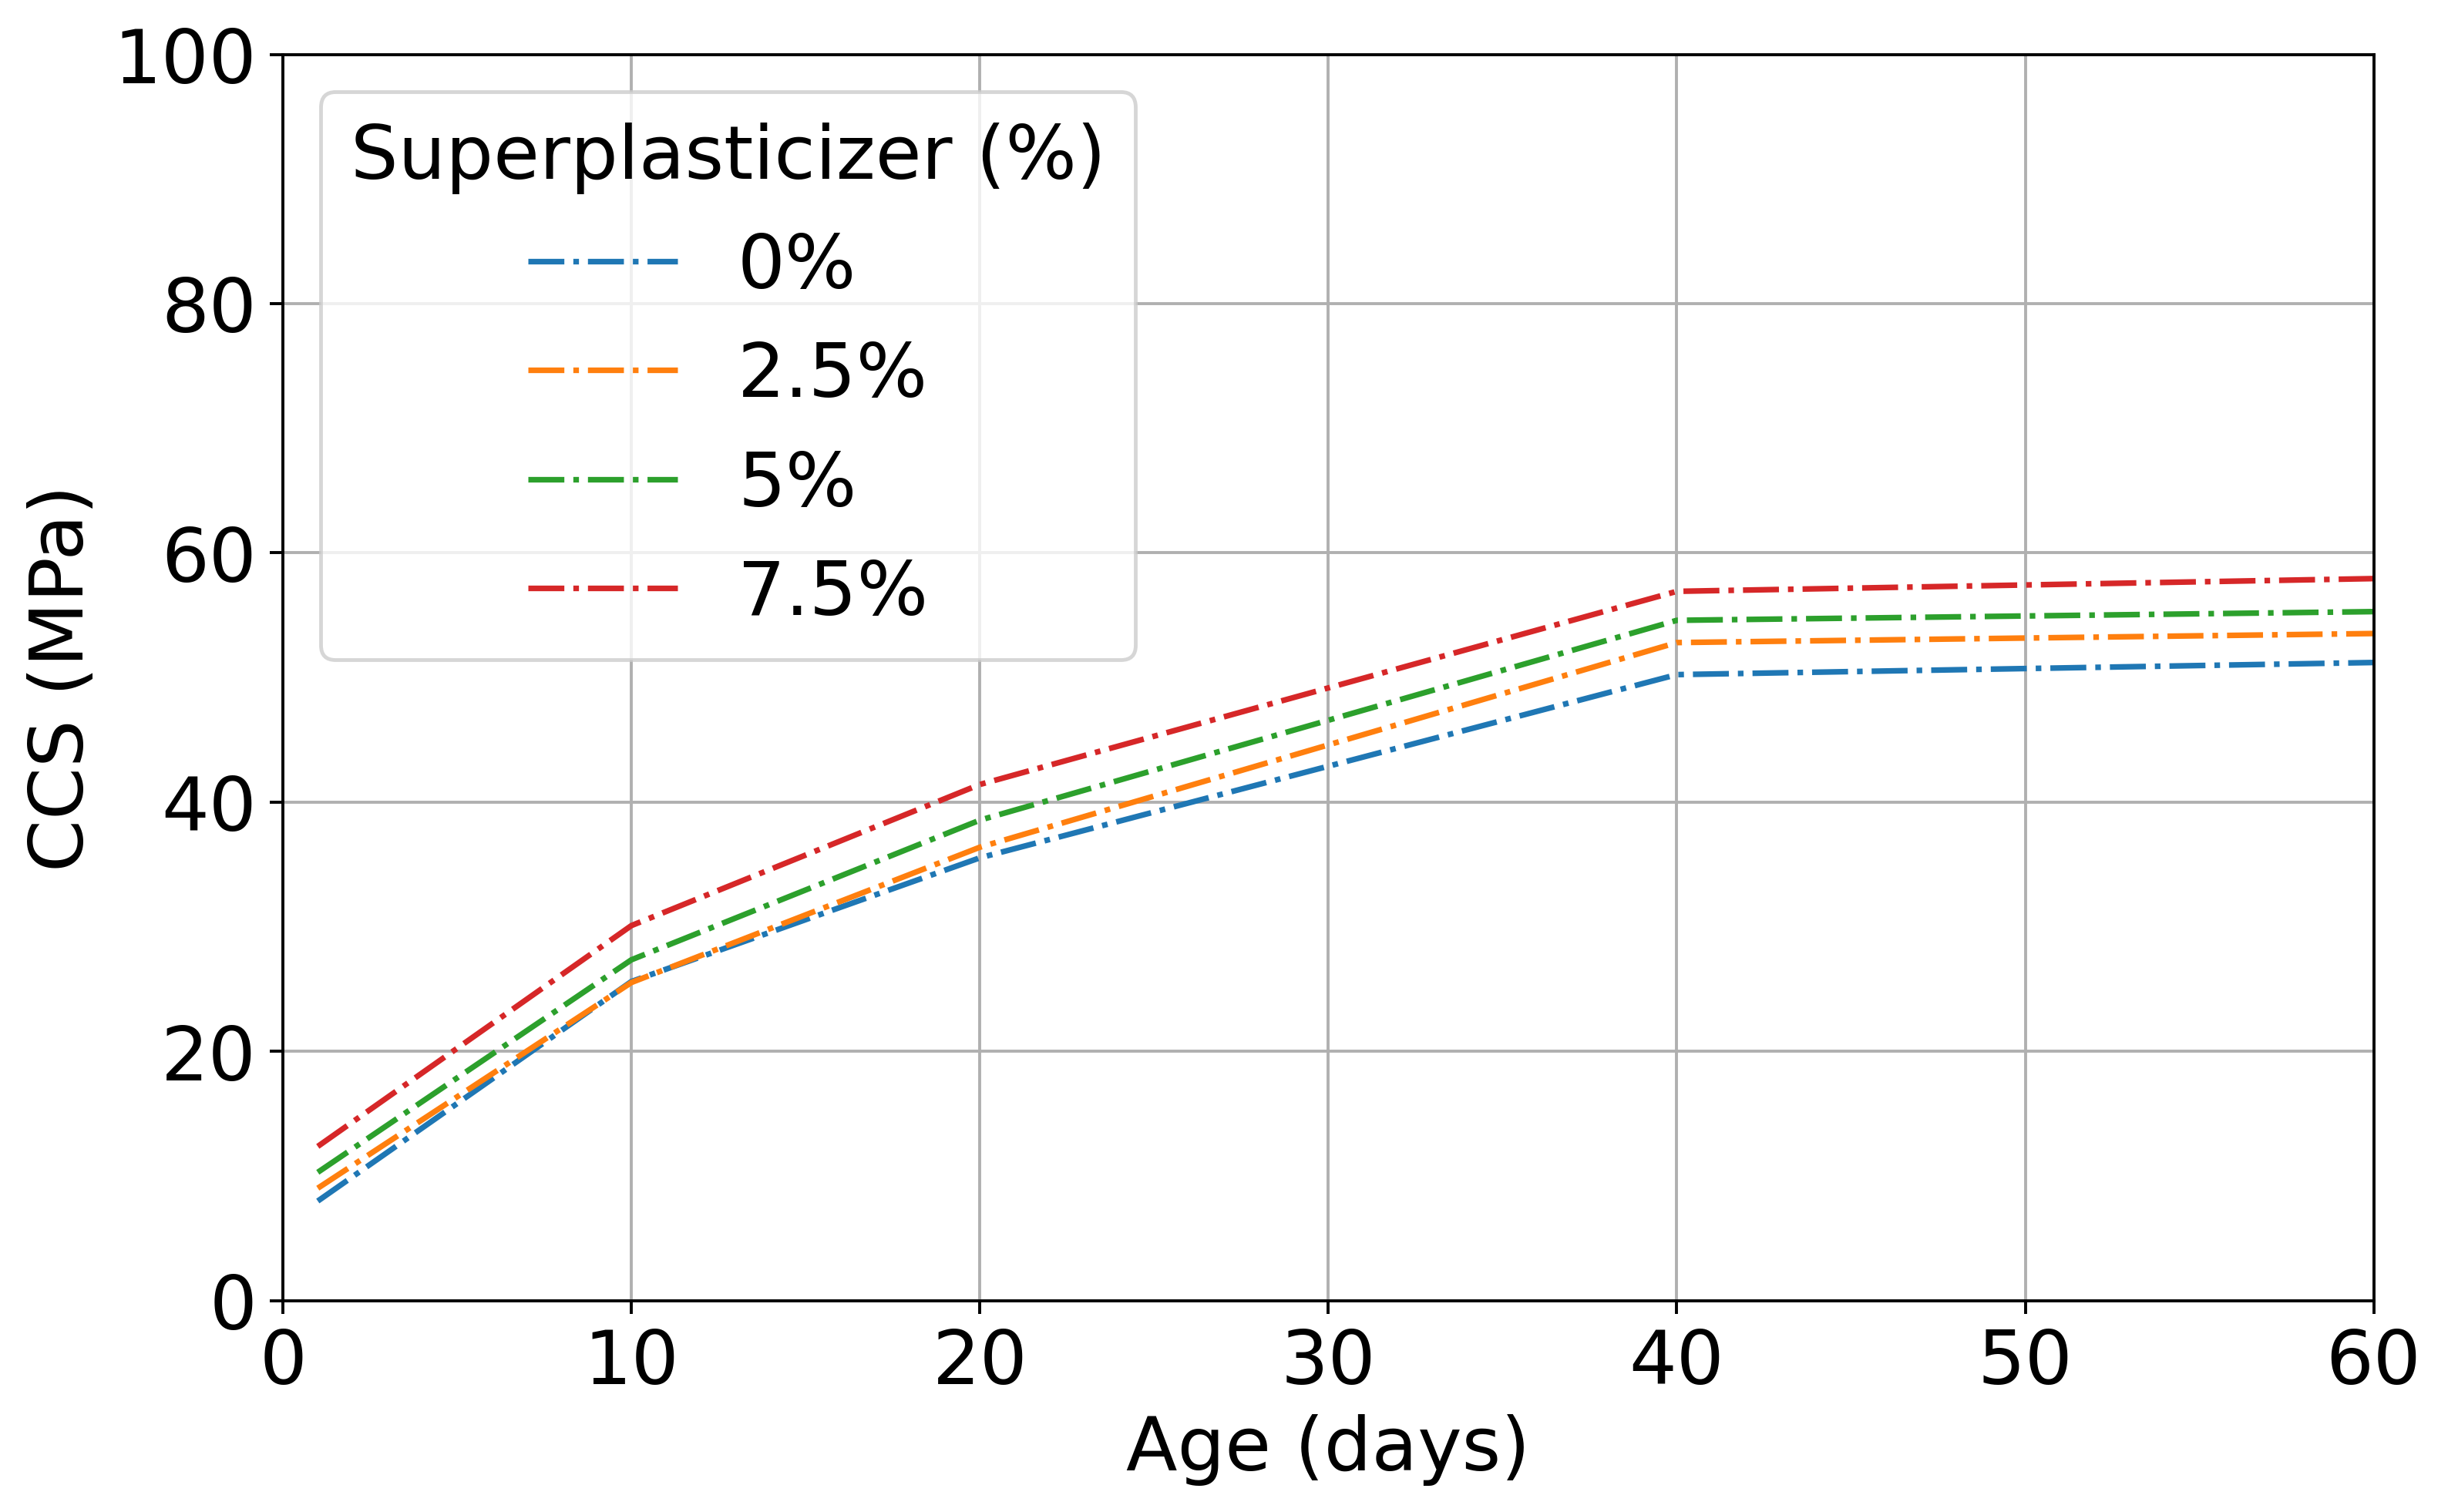

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters based on the provided relations
total_binder = 407.64  # Total Binder value

# Constant values for the rest of the parameters
coarse_aggregate = 974.81  # CA/FA = 1.2 (Fixed value)
fine_aggregate = coarse_aggregate / 1.2  # Fine Aggregate is adjusted to maintain CA/FA ratio
w_b_ratio = 0.3  # Fixed Water-to-Binder Ratio

# List of ages to test
ages = np.array([1, 10, 20, 40, 120])

# BFS/B and FA/B percentages to vary from 0% to 30%, fix BFS/B at 12%
bfs_b = 0.12  # BFS/B = 12%
fa_b = bfs_b  # FA/B = BFS/B

# Range of superplasticizer percentages to test
superplasticizer_percentages = [0,2.5,5,7.5]  # Varying from 0% to 20%

# Plot initialization
plt.figure(figsize=(10, 6), dpi=350)

# Loop over different superplasticizer percentages
for sp in superplasticizer_percentages:
    predictions = []  # Reset predictions for the current superplasticizer percentage

    # Calculate BFS and FA based on their percentages
    blast_furnace_slag = bfs_b * total_binder  # BFS/B = percentage of Total Binder
    fly_ash = fa_b * total_binder  # FA/B = percentage of Total Binder

    # Adjust cement based on BFS and FA content
    cement = total_binder - (blast_furnace_slag + fly_ash)

    # Generate predictions for each age
    for age in ages:
        # Construct input array, where W/B ratio is multiplied by Total Binder to get Water content
        water = w_b_ratio * total_binder  # Water content is W/B ratio * Total Binder

        # Create the feature vector (Input features to the model)
        input_features = np.array([[cement, blast_furnace_slag, fly_ash, water, sp,
                                    coarse_aggregate, fine_aggregate, age]])

        # Scale the input features using the pre-trained scaler
        input_scaled = scaler_X.transform(input_features)

        # Convert input to a torch tensor and predict the Concrete Compressive Strength
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward prediction: Concrete Compressive Strength (CCS)
        forward_pred, _ = model(input_tensor)

        # Inverse transform the output (predicted CCS)
        predicted_strength = scaler_y.inverse_transform(forward_pred.cpu().detach().numpy())

        # Store the prediction
        predictions.append(predicted_strength[0][0])

    # Plot the results for the current superplasticizer percentage
    plt.plot(ages, predictions, label=f'{sp}%', linestyle='dashdot')

# Adding labels and title
plt.xlabel("Age (days)", fontsize=20)
plt.ylabel("CCS (MPa)", fontsize=20)
plt.xlim(0, 60)
plt.ylim(0, 100)
# plt.title("Concrete Compressive Strength vs. Age for Different Superplasticizer Percentages", fontsize=20)
plt.legend(title="Superplasticizer (%)", fontsize=20, title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)

plt.grid(True)
plt.show()
